# Group BJ PVA Project (Data Mining Winter Term 2020/2021)

#### Total runtime: around 25 minutes

In [ ]:
#the following packages might have to be installed to run the code, remove the "#" for that
import sys
#!pip install geopandas
#!pip install descartes
#!{sys.executable} -m pip install -U pandas-profiling
#!jupyter nbextension enable --py widgetsnbextension

#import the needed libraries
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import geopandas
import numpy as np
import seaborn as sns
from datetime import datetime
from sklearn.cluster import KMeans
from datetime import datetime
import datetime
from scipy import stats
from sklearn.preprocessing import StandardScaler
import sys

from pandas_profiling import ProfileReport
from sklearn.impute import KNNImputer
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import scale
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth
from sklearn.impute import KNNImputer

sns.set_style("whitegrid")
sns.set_palette("pastel")

# Importing the data

In [4]:
#import the data
donors = pd.read_csv("donors.csv")
donors_original = pd.read_csv("donors.csv")

In [5]:
#check the shape
donors.shape

(95412, 476)

In [6]:
donors.head()

,Unnamed: 0,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,...,AVGGIFT,CONTROLN,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,GEOCODE2
0,0,2009-01-01,GRI,0,IL,61081,,,1957-12-01,0,...,7.741935,95515,0,L,4,E,X,X,X,C
1,1,2014-01-01,BOA,1,CA,91326,,,1972-02-01,0,...,15.666667,148535,0,L,2,G,X,X,X,A
2,2,2010-01-01,AMH,1,NC,27017,,,NaN,0,...,7.481481,15078,1,L,4,E,X,X,X,C
3,3,2007-01-01,BRY,0,CA,95953,,,1948-01-01,0,...,6.812500,172556,1,L,4,E,X,X,X,C
4,4,2006-01-01,,0,FL,33176,,,1940-01-01,0,...,6.864865,7112,1,L,2,F,X,X,X,A


In [7]:
#drop the first column, that is the same as the index and therefore redundant
donors = donors.drop(columns=["Unnamed: 0"])

In [8]:
#drop CONTROLN as it is a unique identifier and not relevant for clustering purposes
print("Is CONTROLN a unique identifier?:", len(donors["CONTROLN"].value_counts()) == len(donors))
donors = donors.drop(columns=["CONTROLN"])

Is CONTROLN a unique identifier?: True


In [9]:
#checking for duplicates
donors.drop_duplicates().shape
#there are none

(95412, 474)

In [10]:
#checking the data types of the columns
donors.dtypes.value_counts()

int64      300
object     125
float64     49
dtype: int64

# Dropping columns

In the following, there will often be columns that get dropped. This will be due to two major reasons:
* high percentage of missing values within feature
* low variation within feature

Both of these reasons make the feature very unsuitable for clustering purposes.

# Dealing with the dates in object format

There are several dates in the features. However, they are all in an object type so we have to transform them.

In [11]:
dates = ["ODATEDW", "DOB", "ADATE_2", "ADATE_3", "ADATE_4", "ADATE_5", "ADATE_6", "ADATE_7", "ADATE_8", "ADATE_9", "ADATE_10", "ADATE_11", "ADATE_12", "ADATE_13", "ADATE_14", "ADATE_15", "ADATE_16", "ADATE_17", "ADATE_18", "ADATE_19", "ADATE_20", "ADATE_21", "ADATE_22", "ADATE_23", "ADATE_24", "MAXADATE", "RDATE_3", "RDATE_4", "RDATE_5", "RDATE_6", "RDATE_7", "RDATE_8", "RDATE_9", "RDATE_10", "RDATE_11", "RDATE_12", "RDATE_13", "RDATE_14", "RDATE_15", "RDATE_16", "RDATE_17", "RDATE_18", "RDATE_19", "RDATE_20", "RDATE_21", "RDATE_22", "RDATE_23", "RDATE_24", "MINRDATE", "MAXRDATE", "LASTDATE", "FISTDATE", "NEXTDATE"]

In [12]:
for element in dates:
    donors[element] = pd.to_datetime(donors[element], format='%Y-%m-%d')

First of all, as the DataFrame is obviously outdated, we need to find an appropriate date that we can treat as the most up-to-date date:

In [13]:
donors[dates].max().sort_values(ascending=False).head()

RDATE_3    2018-06-01
RDATE_8    2018-06-01
RDATE_10   2018-06-01
RDATE_12   2018-06-01
RDATE_16   2018-05-01
dtype: datetime64[ns]

These are all dates for gifts that got sent back. But we should probably consider the last date when a promotion got sent out, so let's have a look at the most recent promotion that was sent out, NK17:

In [14]:
current_date = donors["ADATE_2"].max()
print(donors["ADATE_2"].max())

2017-06-01 00:00:00


Okay, here we go, let's use this date as the current one.

### DOB

From the DOB column we can retrieve the Age of each individual:

In [15]:
def age(date):
    return (current_date - date)

def make_int(floaty):
    try:
        return int(floaty)
    except:
        return np.nan

donors["AGE"] = donors["DOB"].apply(age)
donors = donors.drop(columns=["DOB"])
donors["AGE"] = donors["AGE"].dt.days/365
donors["AGE"] = donors["AGE"].apply(make_int)

There are a lot of nan values in the AGE column. There are different approaches for replacing them. Three major ones are to replace them with:
1. The mean
2. The median
3. The most frequent

In [16]:
print("AGE mean:", np.round(donors["AGE"].mean()))
print("AGE median:", np.round(donors["AGE"].median()))
print("AGE most frequent:", np.round(donors["AGE"].value_counts().idxmax()))

AGE mean: 59.0
AGE median: 59.0
AGE most frequent: 49.0


As both, the mean and the median are the same, it seems reasonable to take this value for replacing the nans.

In [17]:
donors["AGE"] = donors["AGE"].replace(np.nan, np.round(donors["AGE"].mean()))

### ADATE and RDATE 

The following cells are all concerning certain promotions, more specific on when they were mailed and when there were gifts received for them:

In [18]:
a_and_r = ["ADATE_" + str(i) for i in range(2,25)]
a_and_r = a_and_r + ["RDATE_" + str(i) for i in range(3,25)]

We can for example just calculate the time that each date lies in the past, however, this might not be very useful as the older promotions obviously lie more days in the past and therefore also the respective gifts are. We can also try to get the most useful information out of these columns, which is for example the timelag between the mailing and the gift reception:

In [19]:
i = 2
j = 0
amount_promotion = []
percentage_that_gifted = []

for element in a_and_r:
    print(element, ":", donors[element].isna().value_counts()[False])
    if i > 2:
        amount_promotion.append(donors[element].isna().value_counts()[False])
    if i > 24:
        percentage_that_gifted.append((donors[element].isna().value_counts()[False]/amount_promotion[j])*100)
        j = j + 1
    i = i + 1

ADATE_2 : 95412
ADATE_3 : 93462
ADATE_4 : 93221
ADATE_5 : 61822
ADATE_6 : 91855
ADATE_7 : 86538
ADATE_8 : 91901
ADATE_9 : 84167
ADATE_10 : 62664
ADATE_11 : 84990
ADATE_12 : 86489
ADATE_13 : 55193
ADATE_14 : 76545
ADATE_15 : 29935
ADATE_16 : 75048
ADATE_17 : 67762
ADATE_18 : 74149
ADATE_19 : 70932
ADATE_20 : 45212
ADATE_21 : 60200
ADATE_22 : 69764
ADATE_23 : 39142
ADATE_24 : 58439
RDATE_3 : 242
RDATE_4 : 281
RDATE_5 : 9
RDATE_6 : 776
RDATE_7 : 8895
RDATE_8 : 21472
RDATE_9 : 16734
RDATE_10 : 10461
RDATE_11 : 14740
RDATE_12 : 25700
RDATE_13 : 12250
RDATE_14 : 23317
RDATE_15 : 7262
RDATE_16 : 26994
RDATE_17 : 9401
RDATE_18 : 19778
RDATE_19 : 15877
RDATE_20 : 7888
RDATE_21 : 9513
RDATE_22 : 20873
RDATE_23 : 7859
RDATE_24 : 17738


After counting the nan values, we can draw several conclusions:
* the number of mailed promotions seems to increase over time, and so the latest promotion that got sent out got sent to the highest number of donors
* there have apparently not been any receptions for gifts of the latest promotion (ADATE_2)

For clustering purposes, however, we have to drop all the RDATE columns, as there are just too many nan values in them to be useful (always above 70% missing values!).

In [20]:
donors = donors.drop(columns = ["RDATE_" + str(i) for i in range(3,25)])

We can keep the ADATES for now, but we need to transform them into a useable format. We will transform them into the respective amount of days that they lie in the past:

In [21]:
def days(date):
    return (current_date - date)

for element in ["ADATE_" + str(i) for i in range(2,25)]:
    donors[element] = donors[element].apply(days).dt.days

In [22]:
donors[["ADATE_" + str(i) for i in range(2,25)]].mean()

ADATE_2        0.008311
ADATE_3      365.011748
ADATE_4      425.274005
ADATE_5      426.000000
ADATE_6      457.033313
ADATE_7      487.843421
ADATE_8      519.162185
ADATE_9      580.228771
ADATE_10     606.476031
ADATE_11     615.361960
ADATE_12     656.476592
ADATE_13     701.869676
ADATE_14     731.130694
ADATE_15     792.000000
ADATE_16     822.425834
ADATE_17     853.470337
ADATE_18     894.827213
ADATE_19     944.365364
ADATE_20     942.990710
ADATE_21     976.160299
ADATE_22    1003.090261
ADATE_23    1066.305401
ADATE_24    1096.147470
dtype: float64

As we can see, the average days that these promotions lie behind is always getting higher. That is because the older promotions obviously lie more in the past. It is doubtful if these columns with their provided information will be useful for latter clustering purposes.

In [23]:
donors[["ADATE_" + str(i) for i in range(2,25)]].max() - donors[["ADATE_" + str(i) for i in range(2,25)]].min()

ADATE_2      61.0
ADATE_3      61.0
ADATE_4     305.0
ADATE_5       0.0
ADATE_6      60.0
ADATE_7      62.0
ADATE_8     182.0
ADATE_9      61.0
ADATE_10     31.0
ADATE_11     92.0
ADATE_12     92.0
ADATE_13    150.0
ADATE_14     61.0
ADATE_15      0.0
ADATE_16     59.0
ADATE_17     59.0
ADATE_18    334.0
ADATE_19     61.0
ADATE_20     30.0
ADATE_21     30.0
ADATE_22    304.0
ADATE_23    212.0
ADATE_24     31.0
dtype: float64

In [24]:
for element in ["ADATE_" + str(i) for i in range(2,25)]:
    print(donors[element].value_counts().head(), donors[element].value_counts().tail(), "\n")

0     95399
61       13
Name: ADATE_2, dtype: int64 0     95399
61       13
Name: ADATE_2, dtype: int64 

365.0    93444
426.0       18
Name: ADATE_3, dtype: int64 365.0    93444
426.0       18
Name: ADATE_3, dtype: int64 

426.0    92405
335.0      403
396.0      199
273.0      178
457.0       21
Name: ADATE_4, dtype: int64 273.0    178
457.0     21
486.0      6
548.0      6
578.0      3
Name: ADATE_4, dtype: int64 

426.0    61822
Name: ADATE_5, dtype: int64 426.0    61822
Name: ADATE_5, dtype: int64 

457.0    91804
517.0       51
Name: ADATE_6, dtype: int64 457.0    91804
517.0       51
Name: ADATE_6, dtype: int64 

486.0    81512
517.0     4906
548.0      120
Name: ADATE_7, dtype: int64 486.0    81512
517.0     4906
548.0      120
Name: ADATE_7, dtype: int64 

517.0    85468
548.0     6360
578.0       51
457.0       18
396.0        4
Name: ADATE_8, dtype: int64 517.0    85468
548.0     6360
578.0       51
457.0       18
396.0        4
Name: ADATE_8, dtype: int64 

578.0    80718
6

As we have now obtained a closer look into the distribution of the ADATEs, we can definitely drop these features due to a lack of variation!

In [25]:
donors = donors.drop(columns = ["ADATE_" + str(i) for i in range(2,25)])

We might have dropped the ADATEs and the RDATEs as they don't fit our clustering purposes, however, there is still some information that we can take from them:

In [26]:
promotions = ["96NK promotion (3)", "96TK promotion (4)", "96SK promotion (5)", "96LL promotion (6)", "96G1 promotion (7)",
"96GK promotion (8)", "96CC promotion (9)", "96WL promotion (10)", "96X1 promotion (11)", "96XK promotion (12)",
"95FS promotion (13)", "95NK promotion (14)", "95TK promotion (15)", "95LL promotion (16)", "95G1 promotion (17)",
"95GK promotion (18)", "95CC promotion (19)", "95WL promotion (20)", "95X1 promotion (21)", "95XK promotion (22)",
"94FS promotion (23)", "94NK promotion (24)"]

promotions_percentage = pd.DataFrame(percentage_that_gifted, promotions).rename(columns={0:"percentage that gifted"})
promotions_percentage

,percentage that gifted
96NK promotion (3),0.258929
96TK promotion (4),0.301434
96SK promotion (5),0.014558
96LL promotion (6),0.844810
96G1 promotion (7),10.278721
96GK promotion (8),23.364272
96CC promotion (9),19.881901
96WL promotion (10),16.693795
96X1 promotion (11),17.343217
96XK promotion (12),29.714761


The most effective promotions in terms of the percentage of gift reception were:

In [27]:
promotions_percentage.sort_values(by="percentage that gifted", ascending = False).head()

,percentage that gifted
95LL promotion (16),35.968980
95NK promotion (14),30.461820
94NK promotion (24),30.353018
95XK promotion (22),29.919443
96XK promotion (12),29.714761


However, this might be a bit biased as these are mostly older promotions, so there was in general more time for the donors to donate. But these five still have a remarkable share of response, so maybe they should be looked at closer and be used as a template for future promotions.

### Min and Max Dates

The following variables might give us some more details of the donors behaviour:

In [28]:
min_max= ["ODATEDW", "MAXADATE", "MINRDATE", "MAXRDATE", "LASTDATE", "FISTDATE", "NEXTDATE"]

Here it also makes sense to calculate the days that these dates lie in the past:

In [29]:
for element in min_max:
    donors[element] = donors[element].apply(days).dt.days

In [30]:
donors[min_max].corr()

,ODATEDW,MAXADATE,MINRDATE,MAXRDATE,LASTDATE,FISTDATE,NEXTDATE
ODATEDW,1.000000,-0.006875,0.772955,0.464558,-0.017462,0.986574,0.969990
MAXADATE,-0.006875,1.000000,-0.011018,-0.001887,-0.000092,-0.010066,-0.011344
MINRDATE,0.772955,-0.011018,1.000000,0.255400,0.083778,0.780198,0.726159
MAXRDATE,0.464558,-0.001887,0.255400,1.000000,0.057597,0.474320,0.445383
LASTDATE,-0.017462,-0.000092,0.083778,0.057597,1.000000,-0.021506,-0.013606
FISTDATE,0.986574,-0.010066,0.780198,0.474320,-0.021506,1.000000,0.983523
NEXTDATE,0.969990,-0.011344,0.726159,0.445383,-0.013606,0.983523,1.000000


By looking at the correlations, we can see that there are some highly correlated features. Especially ODATEDW and FIRSTDATE, which is no surprise as the are both representing the first date that a donor has donated (one with a promotion and one overall). We decided to drop ODATEDW, as we still keep NEXTDATE, because it might become an interesting thing to know when and whether a donor donated a second time. And as NEXTDATE is directly linked to FISTDATE, it is better to drop ODATEDW instead of FISTDATE.

In [31]:
donors = donors.drop(columns=["ODATEDW"])
min_max.remove("ODATEDW")

Furthermore, we still need to address the problem of missing values within these columns:

In [32]:
print("Percentage of missing values:\n")
for element in min_max:
    print(element, ":", np.round(100 - donors[element].isna().value_counts()[False]/len(donors)*100,3), "(", donors[element].isna().value_counts()[False], "non nan values)")

Percentage of missing values:

MAXADATE : 0.0 ( 95412 non nan values)
MINRDATE : 0.0 ( 95412 non nan values)
MAXRDATE : 0.0 ( 95412 non nan values)
LASTDATE : 0.0 ( 95412 non nan values)
FISTDATE : 0.002 ( 95410 non nan values)
NEXTDATE : 10.453 ( 85439 non nan values)


As we can see, we have a very low percentage of missing values within these columns. In fact, we only need to replace nans in FISTDATE and NEXTDATE.

In [33]:
print("FISTDATE mean:", np.round(donors["FISTDATE"].mean()))
print("FISTDATE median:", np.round(donors["FISTDATE"].median()))
print("FISTDATE most frequent:", np.round(donors["FISTDATE"].value_counts().idxmax()), "\n")

print("NEXTDATE mean:", np.round(donors["NEXTDATE"].mean()))
print("NEXTDATE median:", np.round(donors["NEXTDATE"].median()))
print("NEXTDATE most frequent:", np.round(donors["NEXTDATE"].value_counts().idxmax()))

FISTDATE mean: 2080.0
FISTDATE median: 1978.0
FISTDATE most frequent: 882.0 

NEXTDATE mean: 2010.0
NEXTDATE median: 1887.0
NEXTDATE most frequent: 792.0


We decide to fill the columns with the median, as it seems to be the "most correct" approach:

In [34]:
donors_co = donors
donors["FISTDATE"] = donors["FISTDATE"].replace(np.nan, np.round(donors["AGE"].median()))

In [35]:
donors[donors["NEXTDATE"].isna()]["FISTDATE"].sort_values().value_counts()

486.0    2109
517.0    2092
639.0    1368
609.0    1247
731.0     889
701.0     587
457.0     522
578.0     471
548.0     426
670.0     114
792.0      73
762.0      51
823.0      24
Name: FISTDATE, dtype: int64

#### Should we drop the columns with no NEXTDATE instead?

* They are very unlikely to donate again, and might so bias our clustering
* They have not donated since at least 486 days, so we lost them by almost 100%

-> We decide to drop them, as they are very very unlikely to donate again and therefore are not very fitting for our upcoming clustering approaches! The other way would be to pretend that they have donated multiple times and therefore assign them the median NEXTDATE, which we don't want to do as it would transfer almost 10000 one time donors into donors that donated multiple times!

In [36]:
donors_co = donors_co[~donors_co["NEXTDATE"].isna()]
donors = donors[~donors["NEXTDATE"].isna()]

We should also check for inconsitencies, so we also drop the entries that have only given one gift according to the NGIFTALL feature. These are only 35:

In [37]:
donors.shape

(85439, 428)

In [38]:
donors["NGIFTALL"].value_counts()[1]

35

In [39]:
donors = donors[donors["NGIFTALL"] != 1]
donors_co = donors_co[donors_co["NGIFTALL"] != 1]

In [40]:
donors.dtypes.value_counts()

int64      304
object      72
float64     52
dtype: int64

In [41]:
donors.shape

(85404, 428)

### Lapsing donors

As we have transformed all the dates now, we can check the data for lapsing donors by using the current date found above and the LASTDATE column that tells us when a donors last donation took place.

In [42]:
#displaying the number of observations grouped by the amount of days their last donation lies behind
days_past = pd.DataFrame(donors["LASTDATE"].value_counts()).reset_index().rename(columns={"index":"Days in the past"}).sort_values(by="Days in the past")
days_past

,Days in the past,LASTDATE
12,120,819
14,151,745
13,182,766
16,212,432
17,243,407
18,273,280
20,304,208
23,335,144
22,365,148
19,396,220


Lapsed donors are donors, that donated in the last 12-24 months, so their days in the past would be between 365 days and 792 days (as 2016 was a lap year). Let's count how many donors are lapsed donors:

In [43]:
days_past[(days_past["Days in the past"] <= 731) & (days_past["Days in the past"] >= 365)].sum().iloc[1]

74436

There are 74436 lapsing donors within our remaining DataFrame, so a vast majority of almost 90%. We will have a look at them again after our clustering is done.

# Creating subsets

As we have a very high amount of columns in our DataFrame, we will now create several subsets for them. Thereby, we try to find the most similar features concerning their given information and group them together. This will help us to better understand the DataFrame as well as to prepare the Data for the clustering.

### subset: Neighbourhood

In [44]:
donors_copy = donors.copy()

The following variables reflect characteristics of the donors neighborhood, as collected from the 2010 US Census.

In [45]:
neighbourhood = ['POP901', 'POP902', 'POP903', 'POP90C1', 'POP90C2', 'POP90C3', 'POP90C4', 'POP90C5', 'ETH1', 'ETH2', 'ETH3', 'ETH4', 'ETH5', 'ETH6', 'ETH7', 'ETH8', 'ETH9', 'ETH10', 'ETH11', 'ETH12', 'ETH13', 'ETH14', 'ETH15', 'ETH16', 'AGE901', 'AGE902', 'AGE903', 'AGE904', 'AGE905', 'AGE906', 'AGE907', 'CHIL1', 'CHIL2', 'CHIL3', 'AGEC1', 'AGEC2', 'AGEC3', 'AGEC4', 'AGEC5', 'AGEC6', 'AGEC7', 'CHILC1', 'CHILC2', 'CHILC3', 'CHILC4', 'CHILC5', 'HHAGE1', 'HHAGE2', 'HHAGE3', 'HHN1', 'HHN2', 'HHN3', 'HHN4', 'HHN5', 'HHN6', 'MARR1', 'MARR2', 'MARR3', 'MARR4', 'HHP1', 'HHP2', 'DW1', 'DW2', 'DW3', 'DW4', 'DW5', 'DW6', 'DW7', 'DW8', 'DW9', 'HV1', 'HV2', 'HV3', 'HV4', 'HU1', 'HU2', 'HU3', 'HU4', 'HU5', 'HHD1', 'HHD2', 'HHD3', 'HHD4', 'HHD5', 'HHD6', 'HHD7', 'HHD8', 'HHD9', 'HHD10', 'HHD11', 'HHD12', 'ETHC1', 'ETHC2', 'ETHC3', 'ETHC4', 'ETHC5', 'ETHC6', 'HVP1', 'HVP2', 'HVP3', 'HVP4', 'HVP5', 'HVP6', 'HUR1', 'HUR2', 'RHP1', 'RHP2', 'RHP3', 'RHP4', 'HUPA1', 'HUPA2', 'HUPA3', 'HUPA4', 'HUPA5', 'HUPA6', 'HUPA7', 'RP1', 'RP2', 'RP3', 'RP4', 'MSA', 'ADI', 'DMA', 'IC1', 'IC2', 'IC3', 'IC4', 'IC5', 'IC6', 'IC7', 'IC8', 'IC9', 'IC10', 'IC11', 'IC12', 'IC13', 'IC14', 'IC15', 'IC16', 'IC17', 'IC18', 'IC19', 'IC20', 'IC21', 'IC22', 'IC23', 'HHAS1', 'HHAS2', 'HHAS3', 'HHAS4', 'MC1', 'MC2', 'MC3', 'TPE1', 'TPE2', 'TPE3', 'TPE4', 'TPE5', 'TPE6', 'TPE7', 'TPE8', 'TPE9', 'PEC1', 'PEC2', 'TPE10', 'TPE11', 'TPE12', 'TPE13', 'LFC1', 'LFC2', 'LFC3', 'LFC4', 'LFC5', 'LFC6', 'LFC7', 'LFC8', 'LFC9', 'LFC10', 'OCC1', 'OCC2', 'OCC3', 'OCC4', 'OCC5', 'OCC6', 'OCC7', 'OCC8', 'OCC9', 'OCC10', 'OCC11', 'OCC12', 'OCC13', 'EIC1', 'EIC2', 'EIC3', 'EIC4', 'EIC5', 'EIC6', 'EIC7', 'EIC8', 'EIC9', 'EIC10', 'EIC11', 'EIC12', 'EIC13', 'EIC14', 'EIC15', 'EIC16', 'OEDC1', 'OEDC2', 'OEDC3', 'OEDC4', 'OEDC5', 'OEDC6', 'OEDC7', 'EC1', 'EC2', 'EC3', 'EC4', 'EC5', 'EC6', 'EC7', 'EC8', 'SEC1', 'SEC2', 'SEC3', 'SEC4', 'SEC5', 'AFC1', 'AFC2', 'AFC3', 'AFC4', 'AFC5', 'AFC6', 'VC1', 'VC2', 'VC3', 'VC4', 'ANC1', 'ANC2', 'ANC3', 'ANC4', 'ANC5', 'ANC6', 'ANC7', 'ANC8', 'ANC9', 'ANC10', 'ANC11', 'ANC12', 'ANC13', 'ANC14', 'ANC15', 'POBC1', 'POBC2', 'LSC1', 'LSC2', 'LSC3', 'LSC4', 'VOC1', 'VOC2', 'VOC3', 'HC1', 'HC2', 'HC3', 'HC4', 'HC5', 'HC6', 'HC7', 'HC8', 'HC9', 'HC10', 'HC11', 'HC12', 'HC13', 'HC14', 'HC15', 'HC16', 'HC17', 'HC18', 'HC19', 'HC20', 'HC21', 'MHUC1', 'MHUC2', 'AC1', 'AC2', "DOMAIN"]

In [46]:
#creating a dataframe that contains only the neighboorhood data
subset_neighbourhood = donors[neighbourhood]
donors_copy = donors_copy.drop(columns = neighbourhood)

There are a lot of percentages within these neighbourhood columns. So we take a closer look at the ones that are not percentages.

In [47]:
not_percentages = ["POP901", "POP902", "POP903", "AGE901", "AGE902", "AGE903", "AGE904", "AGE905", "AGE906", "HHP1", "HHP2", "DW9", "HV1", "HV2", "HV3", "HV4", "HUR1", "RHP1", "RHP2", "RHP3", "RHP4", "IC1", "IC2", "IC3", "IC4", "IC5", "TPE10", "TPE11", "EC1", "MHUC1", "MHUC2"]
for element in not_percentages:
    neighbourhood.remove(element)

In [48]:
codes = ["MSA", "ADI", "DMA", "DOMAIN"]
for element in codes:
    neighbourhood.remove(element)

For the percentage columns, we concluded that an outlier removal is not very suitable, so we don't perform one. However, we check if there are any values higher than 100 or below 0:

In [49]:
for element in neighbourhood:
    if subset_neighbourhood[element].max() > 100:
        print(element)
    if subset_neighbourhood[element].min() < 0:
        print(element)

for element in neighbourhood:
    if len(subset_neighbourhood[element].dropna()) != len(subset_neighbourhood):
        print(element)
        
#there is no output so we can leave these columns as they are for now, as they have "no outliers" nor any nans

##### Outlier Removal and Nans

Let's check the non percentage features for outliers and nans now:

In [50]:
for element in not_percentages:
    if len(subset_neighbourhood[element].dropna()) != len(subset_neighbourhood):
        print(element)
        
#there are no nans in these columns

In [51]:
for element in not_percentages:
    subset_neighbourhood[element] = subset_neighbourhood[element].apply(float)

for element in not_percentages:
    q25 = subset_neighbourhood[element].quantile(0.25)
    q75 = subset_neighbourhood[element].quantile(0.75)
    iqr = q75 - q25
    low = q25 - 6 * iqr
    high = q75 + 6 * iqr
    
    series = subset_neighbourhood[element].between(low, high, inclusive=True)
    for index in series[series==False].index.tolist():
        subset_neighbourhood.loc[index, element] = np.nan
    
    try:
        print(element, ":", np.round(subset_neighbourhood[element].isna().value_counts()[True]/len(subset_neighbourhood),2)*100)
    except:
        0

<ipython-input-51-f1e5b9653e37>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/franz/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



POP901 : 3.0
POP902 : 3.0
POP903 : 3.0
AGE901 : 0.0
AGE905 : 1.0
AGE906 : 1.0
HHP1 : 0.0
HHP2 : 0.0
DW9 : 12.0
HV1 : 1.0
HV2 : 0.0
HUR1 : 1.0
RHP3 : 1.0
RHP4 : 0.0
IC5 : 0.0
TPE10 : 0.0


We can see that the only column where we drop a too large amount of the data is DW9, so we have a closer look into this column:

In [52]:
subset_neighbourhood["DW9"].value_counts()

0.0    74810
Name: DW9, dtype: int64

We can see that it has a very low variation, so we drop the feature.

In [53]:
subset_neighbourhood = subset_neighbourhood.drop(columns=["DW9"])
not_percentages.remove("DW9")

For the rest, we can fill the nans with the medians, as these are all average and median values:

In [54]:
for element in not_percentages:
    subset_neighbourhood[element] = subset_neighbourhood[element].replace(np.nan, subset_neighbourhood[element].median())

The following codes are not metric features, the are more some kind of zip code like features, so they are not suitable for clustering. The also contain some nan values. 

In [55]:
for element in codes:
    if len(subset_neighbourhood[element].dropna()) != len(subset_neighbourhood):
        print(element, np.round(100 - np.round(len(subset_neighbourhood[element].dropna())/len(subset_neighbourhood), 4)*100,4))

MSA 0.14
ADI 0.14
DMA 0.14


In [56]:
subset_neighbourhood_metric = subset_neighbourhood.drop(columns=codes)

##### Checking for high correlation

We should still check if there are any highly correlated columns among them:

In [57]:
cor_matrix = subset_neighbourhood_metric.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))

We now drop the columns with a correltion of higher than 95% (of course always only one of them)

In [58]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
subset_neighbourhood_metric = subset_neighbourhood_metric.drop(columns=to_drop)

In [59]:
to_drop

['AGE903',
 'AGE904',
 'AGE906',
 'HHAGE3',
 'HHN4',
 'HHP1',
 'HHP2',
 'DW2',
 'DW5',
 'DW6',
 'HHD1',
 'HHD9',
 'ETHC4',
 'ETHC5',
 'RHP2',
 'HUPA2',
 'IC2',
 'IC3',
 'IC4',
 'IC19',
 'IC20',
 'IC23',
 'LFC4',
 'LFC5',
 'EIC1',
 'AFC2',
 'LSC2']

Now we have our almost fully prepared (but yet to be normalized) first subset ready for PCA and clustering!

In [60]:
subset_neighbourhood_metric.head()

,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,...,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2
0,992.0,264.0,332.0,0,35,65,47,53,92,1,...,0,33,65,40,99,99,6.0,2.0,10,7
1,3611.0,940.0,998.0,99,0,0,50,50,67,0,...,0,99,0,99,99,99,20.0,4.0,6,5
2,7001.0,2040.0,2669.0,0,2,98,49,51,96,2,...,15,22,77,17,97,92,9.0,2.0,6,5
3,640.0,160.0,219.0,0,8,92,54,46,61,0,...,16,23,77,22,93,89,16.0,2.0,6,6
4,2520.0,627.0,761.0,99,0,0,46,54,2,98,...,0,99,1,21,99,96,6.0,2.0,7,11


### subset: demographics (&geographical location)

The following subset will contain information about the donors socio demographics:

In [61]:
socio_demographics = ["AGE", "TCODE", "GENDER", "STATE", "ZIP", "MAILCODE", "PVASTATE", "CHILD03", "CHILD07", "CHILD12", "CHILD18", "NUMCHLD", "GEOCODE", "GEOCODE2", "INCOME", "WEALTH1", "WEALTH2", "HOMEOWNR"]

In [62]:
#creating a dataframe that contains only the socio_demographics data
subset_socio_demographics = donors[socio_demographics]
donors_copy = donors_copy.drop(columns = socio_demographics)

In [63]:
subset_socio_demographics.head()

,AGE,TCODE,GENDER,STATE,ZIP,MAILCODE,PVASTATE,CHILD03,CHILD07,CHILD12,CHILD18,NUMCHLD,GEOCODE,GEOCODE2,INCOME,WEALTH1,WEALTH2,HOMEOWNR
0,59.0,0,F,IL,61081,,,,,,,NaN,,C,NaN,NaN,5.0,
1,45.0,1,M,CA,91326,,,,,,M,1.0,02,A,6.0,9.0,9.0,H
2,59.0,1,M,NC,27017,,,,,,,NaN,,C,3.0,1.0,1.0,U
3,69.0,0,F,CA,95953,,,,,,,NaN,,C,1.0,4.0,0.0,U
4,77.0,0,F,FL,33176,,,,,,,1.0,,A,3.0,2.0,NaN,H


As we can see, there are only two metric features within the socio demographics, which are AGE and NUMCHLD.

In [64]:
subset_socio_demographics_metric = subset_socio_demographics[["AGE", "NUMCHLD"]]

In [65]:
subset_socio_demographics_metric.head()

,AGE,NUMCHLD
0,59.0,NaN
1,45.0,1.0
2,59.0,NaN
3,69.0,NaN
4,77.0,1.0


##### Outlier Removal and Nans

In [66]:
print("Percent of missing values in NUMCHLD:", np.round(subset_socio_demographics_metric["NUMCHLD"].isna().value_counts()[True]/len(subset_socio_demographics_metric), 3) * 100)

Percent of missing values in NUMCHLD: 87.2


There is a very high percentage of missing values in the NUMCHLD column. At first, one could argue that the missing values stand for 0 children, but even that 87.2 percent of the donors don't have any children seems to be very unlikely. So we have to drop this column!

In [67]:
subset_socio_demographics_metric = subset_socio_demographics_metric.drop(columns=["NUMCHLD"])
subset_socio_demographics = subset_socio_demographics.drop(columns=["NUMCHLD"])

As we have already dealt with the nan values of the AGE feature, however we still want to check for outliers.

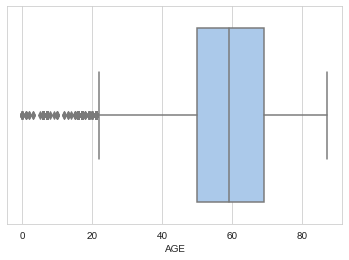

In [68]:
sns.set_style("whitegrid")
sns_plot = sns.boxplot(x=subset_socio_demographics_metric["AGE"])

We can clearly see that there are some outliers on the left, so very young donors. So we decide to declare all donors that have't turned 18 yet as outliers and assign them the value 60.0, similar to the above nan replacement value:

In [69]:
q25 = subset_socio_demographics_metric["AGE"].quantile(0.25)
q75 = subset_socio_demographics_metric["AGE"].quantile(0.75)
iqr = q75 - q25
low = q25 - 1.75 * iqr

In [70]:
below_18 = subset_socio_demographics_metric["AGE"][subset_socio_demographics_metric["AGE"]<low].value_counts().index.tolist()
subset_socio_demographics_metric["AGE"][subset_socio_demographics_metric["AGE"]<low].value_counts()

7.0     238
16.0    152
6.0     145
0.0      13
1.0       4
10.0      4
15.0      4
2.0       2
13.0      2
3.0       2
12.0      2
14.0      1
9.0       1
5.0       1
8.0       1
Name: AGE, dtype: int64

In [71]:
for element in below_18:
    subset_socio_demographics_metric["AGE"] = subset_socio_demographics_metric["AGE"].replace(element, 60.0)

In [72]:
subset_socio_demographics_metric.head()

,AGE
0,59.0
1,45.0
2,59.0
3,69.0
4,77.0


### subset: Responses to other types of mail order offers 

This subset only contains information about the donors' responses to other types of mail order offers. It contains only metric features apart from DATASRCE.

In [73]:
responses_to_others = ["MBCRAFT", "MBGARDEN", "MBBOOKS", "MBCOLECT", "MAGFAML", "MAGFEM", "MAGMALE", "PUBGARDN", "PUBCULIN", "PUBHLTH", "PUBDOITY", "PUBNEWFN", "PUBPHOTO", "PUBOPP", "DATASRCE"]

In [74]:
#creating a dataframe that contains only the responses_to_others data
subset_responses_to_others = donors[responses_to_others]
donors_copy = donors_copy.drop(columns = responses_to_others)

In [75]:
subset_responses_to_others.head()

,MBCRAFT,MBGARDEN,MBBOOKS,MBCOLECT,MAGFAML,MAGFEM,MAGMALE,PUBGARDN,PUBCULIN,PUBHLTH,PUBDOITY,PUBNEWFN,PUBPHOTO,PUBOPP,DATASRCE
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
1,0.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,3
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3
4,1.0,0.0,9.0,0.0,4.0,1.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,1.0,3


##### Outlier Removal and Nans

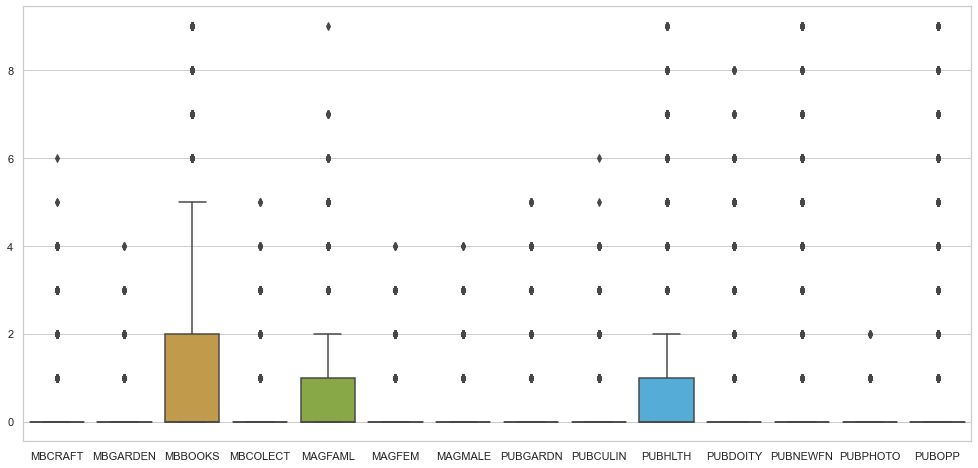

In [76]:
sns.set(rc={'figure.figsize':(17,8)})
sns.set_style("whitegrid")
sns.boxplot(data=subset_responses_to_others)

Before having a closer look at the outliers, we will check the percentage of nan values within these features:

In [77]:
for element in responses_to_others:
    if len(subset_responses_to_others[element].dropna()) != len(subset_responses_to_others):
        print(element, np.round(100 - np.round(len(subset_responses_to_others[element].dropna())/len(subset_responses_to_others), 4)*100,4))

MBCRAFT 54.57
MBGARDEN 54.57
MBBOOKS 54.57
MBCOLECT 54.64
MAGFAML 54.57
MAGFEM 54.57
MAGMALE 54.57
PUBGARDN 54.57
PUBCULIN 54.57
PUBHLTH 54.57
PUBDOITY 54.57
PUBNEWFN 54.57
PUBPHOTO 54.57
PUBOPP 54.57


Oh, there are more than half of the values nans in every column but DATASRCE, so we have no choice but dropping them due to an unsufficient amount of actual values.

In [78]:
responses_to_others_to_drop = ["MBCRAFT", "MBGARDEN", "MBBOOKS", "MBCOLECT", "MAGFAML", "MAGFEM", "MAGMALE", "PUBGARDN", "PUBCULIN", "PUBHLTH", "PUBDOITY", "PUBNEWFN", "PUBPHOTO", "PUBOPP"]
subset_responses_to_others = subset_responses_to_others.drop(columns=responses_to_others_to_drop)
#so this subset is now empty apart from DATASRCE
subset_responses_to_others.head()

,DATASRCE
0,
1,3
2,3
3,3
4,3


### subset: Donors interests

This subset will contain the information about the donors interests:

In [79]:
interests = ["COLLECT1", "VETERANS", "BIBLE", "CATLG", "HOMEE", "PETS", "CDPLAY", "STEREO", "PCOWNERS", "PHOTO", "CRAFTS", "FISHER", "GARDENIN", "BOATS", "WALKER", "KIDSTUFF", "CARDS", "PLATES", "LIFESRC"]

In [80]:
#creating a dataframe that contains only the interests data
subset_interests = donors[interests]
donors_copy = donors_copy.drop(columns = interests)

In [81]:
subset_interests.head()

,COLLECT1,VETERANS,BIBLE,CATLG,HOMEE,PETS,CDPLAY,STEREO,PCOWNERS,PHOTO,CRAFTS,FISHER,GARDENIN,BOATS,WALKER,KIDSTUFF,CARDS,PLATES,LIFESRC
0,,,,,,,,,,,,,,,,,,,
1,,,,,,,,,,,,,,,,,,,
2,,,,,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,,,,,,
4,,,Y,Y,,,,Y,,,Y,,Y,,Y,,Y,,3


As this subset only contains categorical features, it will not be suitable for the clustering. We can only try to potentially get some useful information out of it once we've finished the clustering process!

### subset: Overall donation data

This subset is probably the most important, as it contains all the information that shows us how and what a donor has donated in the past.

In [82]:
overall_donation_data = ['CARDPROM', 'MAXADATE', 'NUMPROM', 'CARDPM12', 'NUMPRM12', 'RAMNTALL', 'NGIFTALL', 'CARDGIFT',
       'MINRAMNT', 'MINRDATE', 'MAXRAMNT', 'MAXRDATE', 'LASTGIFT', 'LASTDATE',
       'FISTDATE', 'NEXTDATE', 'TIMELAG', 'AVGGIFT']

In [83]:
#creating a dataframe that contains only the overall_donation_data data
subset_overall_donation_data = donors[overall_donation_data]
donors_copy = donors_copy.drop(columns = overall_donation_data)

In [84]:
subset_overall_donation_data.head()

,CARDPROM,MAXADATE,NUMPROM,CARDPM12,NUMPRM12,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MINRDATE,MAXRAMNT,MAXRDATE,LASTGIFT,LASTDATE,FISTDATE,NEXTDATE,TIMELAG,AVGGIFT
0,27,120,74,6,14,240.0,31,14,5.0,1765,12.0,1216,10.0,548,2769.0,2649.0,4.0,7.741935
1,12,120,32,6,13,47.0,3,1,10.0,1339,25.0,548,25.0,548,1339.0,792.0,18.0,15.666667
2,26,120,63,6,14,202.0,27,14,2.0,2039,16.0,1796,5.0,548,2708.0,2343.0,12.0,7.481481
3,27,120,66,6,14,109.0,16,7,2.0,3500,11.0,943,10.0,548,3773.0,3500.0,9.0,6.812500
4,43,120,113,10,25,254.0,37,8,3.0,1339,15.0,517,15.0,517,6667.0,6240.0,14.0,6.864865


As displayed, there are only metric features within this subset. Let's check for highly correlating values first:

In [85]:
subset_overall_donation_data.corr()

,CARDPROM,MAXADATE,NUMPROM,CARDPM12,NUMPRM12,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MINRDATE,MAXRAMNT,MAXRDATE,LASTGIFT,LASTDATE,FISTDATE,NEXTDATE,TIMELAG,AVGGIFT
CARDPROM,1.000000,-0.058719,0.932515,0.274127,0.250825,0.513232,0.744040,0.754807,-0.289793,0.657892,0.036338,0.422787,-0.015641,-0.051325,0.901915,0.903800,0.022026,-0.087904
MAXADATE,-0.058719,1.000000,-0.063522,-0.174996,-0.105977,0.008048,0.009543,0.015215,0.002346,-0.011744,-0.001256,-0.001510,-0.004026,0.001880,-0.011066,-0.010932,-0.001086,-0.000615
NUMPROM,0.932515,-0.063522,1.000000,0.278213,0.478952,0.599631,0.765260,0.715174,-0.260702,0.596329,0.086232,0.411117,0.024936,-0.144858,0.844467,0.848626,0.013970,-0.027060
CARDPM12,0.274127,-0.174996,0.278213,1.000000,0.583076,0.176467,0.133700,0.075893,0.009109,-0.035853,0.060277,-0.032090,0.055499,-0.289507,-0.006630,0.006203,-0.043881,0.070669
NUMPRM12,0.250825,-0.105977,0.478952,0.583076,1.000000,0.351468,0.251617,0.123474,0.014375,-0.013507,0.146702,0.022099,0.117241,-0.490187,0.087112,0.097420,-0.029600,0.154773
RAMNTALL,0.513232,0.008048,0.599631,0.176467,0.351468,1.000000,0.567969,0.461708,0.060582,0.293670,0.582621,0.283786,0.369381,-0.105135,0.431244,0.444651,-0.032955,0.497348
NGIFTALL,0.744040,0.009543,0.765260,0.133700,0.251617,0.567969,1.000000,0.904455,-0.342845,0.387174,-0.040666,0.394061,-0.170359,-0.147234,0.689997,0.722547,-0.110780,-0.214628
CARDGIFT,0.754807,0.015215,0.715174,0.075893,0.123474,0.461708,0.904455,1.000000,-0.341628,0.433493,-0.066827,0.388907,-0.181137,-0.083370,0.718964,0.748231,-0.101914,-0.233324
MINRAMNT,-0.289793,0.002346,-0.260702,0.009109,0.014375,0.060582,-0.342845,-0.341628,1.000000,-0.290994,0.269897,-0.071959,0.461506,0.074613,-0.324816,-0.344172,0.073458,0.658525
MINRDATE,0.657892,-0.011744,0.596329,-0.035853,-0.013507,0.293670,0.387174,0.433493,-0.290994,1.000000,0.034407,0.196948,0.074013,0.104195,0.737627,0.725896,0.073432,-0.058441


After seeing the correlation matrix, we will drop three highly correlating columns, "CARDPROM", "CARDGIFT", "NEXTDATE". The all contain information that is redundant, as it is already stored in other features. We decided like that because we obviusly don't want to drop the respective other column, e. g. NUMPROM, as it contains "more" information, because it does not only show the number of card promotions, but the total one. We can also drop the NEXTDATE, as we only have one time donors left in the DataFrame, so it also provides only redundant information. One further thing that seems a bit strange is that CARDPM12 and NUMPM12 doesn't have a super high correlation. However, to stay consequent, we should also drop CARDPM12, as the information is also contained in NUMPRM12!

In [86]:
to_drop_high_corr = ["CARDPROM", "CARDGIFT", "NEXTDATE", "CARDPM12"]
for element in to_drop_high_corr:
    overall_donation_data.remove(element)
subset_overall_donation_data = subset_overall_donation_data.drop(columns = to_drop_high_corr)

##### Outlier Removal and Nans

In [87]:
for element in overall_donation_data:
    if len(subset_overall_donation_data[element].dropna()) != len(subset_overall_donation_data):
        print(element, np.round(100 - np.round(len(subset_overall_donation_data[element].dropna())/len(subset_overall_donation_data), 4)*100,4))

As we can see, there are no nan values within these features, so this problem is already solved. Lets have a closer look into the columns:

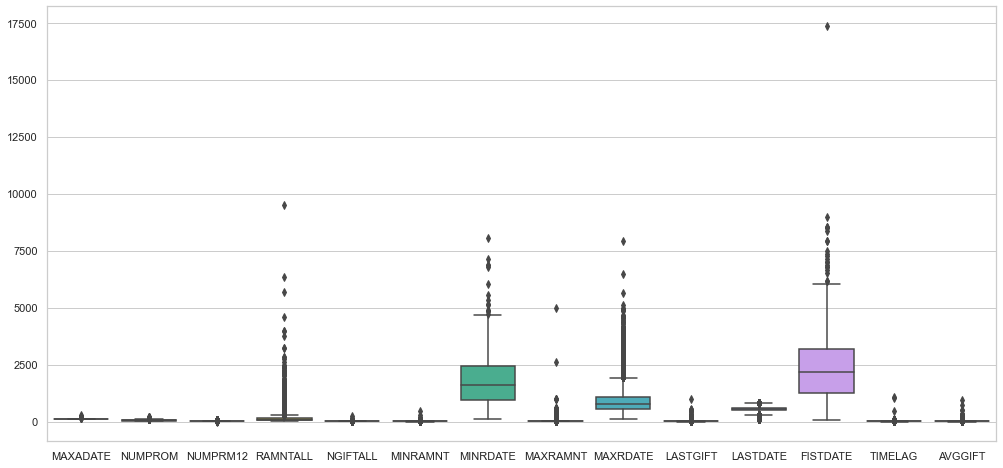

In [88]:
sns.set_style("whitegrid")
sns.boxplot(data=subset_overall_donation_data)

We notice that there might be some features with a very low variation, let's check this:

In [89]:
for element in overall_donation_data:
    print(element, ":", np.round(subset_overall_donation_data[element].value_counts().iloc[0]/len(subset_overall_donation_data), 4)*100)

MAXADATE : 99.59
NUMPROM : 2.1399999999999997
NUMPRM12 : 28.610000000000003
RAMNTALL : 2.78
NGIFTALL : 9.04
MINRAMNT : 40.47
MINRDATE : 2.55
MAXRAMNT : 17.59
MAXRDATE : 11.87
LASTGIFT : 16.85
LASTDATE : 22.8
FISTDATE : 3.46
TIMELAG : 10.05
AVGGIFT : 3.08


We can conclude that we can drop the MAXADATE, as it has basically no variation at all.

In [90]:
overall_donation_data.remove("MAXADATE")
subset_overall_donation_data = subset_overall_donation_data.drop(columns = ["MAXADATE"])

Let's check for the percentage of outliers now by using the IQR method:

In [91]:
for element in overall_donation_data:
    subset_overall_donation_data[element] = subset_overall_donation_data[element].apply(float)

for element in overall_donation_data:
    q25 = subset_overall_donation_data[element].quantile(0.25)
    q75 = subset_overall_donation_data[element].quantile(0.75)
    iqr = q75 - q25
    low = q25 - 6 * iqr
    high = q75 + 6 * iqr
    
    series = subset_overall_donation_data[element].between(low, high, inclusive=True)
    for index in series[series==False].index.tolist():
        subset_overall_donation_data.loc[index, element] = np.nan
    
    try: 
        print(element, ":", np.round(subset_overall_donation_data[element].isna().value_counts()[True]/len(subset_overall_donation_data),2)*100)
    except:
        0
    

NUMPRM12 : 4.0
RAMNTALL : 0.0
NGIFTALL : 0.0
MINRAMNT : 0.0
MAXRAMNT : 1.0
MAXRDATE : 0.0
LASTGIFT : 1.0
FISTDATE : 0.0
TIMELAG : 0.0
AVGGIFT : 0.0


As we can see, there is no significant information loss, so we apply this method and replace the outliers with the respective medians:

In [92]:
for element in overall_donation_data:
    subset_overall_donation_data[element] = subset_overall_donation_data[element].replace(np.nan, subset_overall_donation_data[element].median())

Okay, that better now:

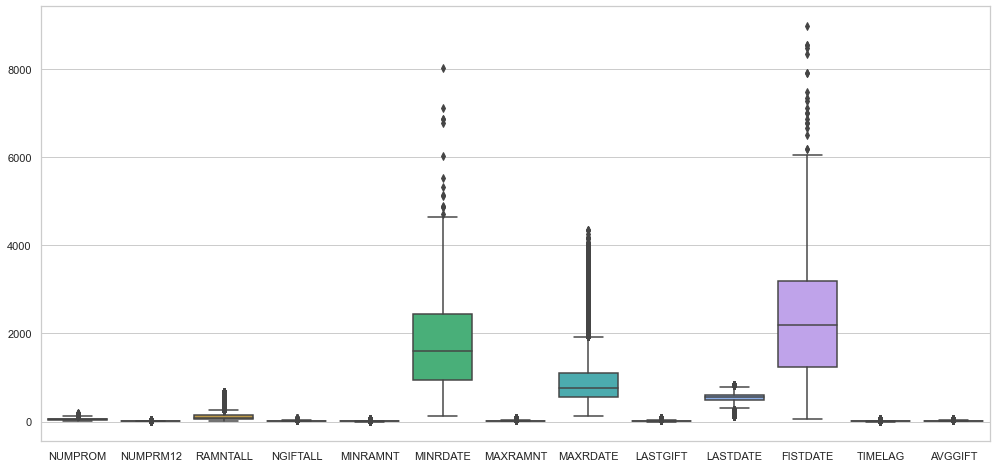

In [93]:
sns.set_style("whitegrid")
sns.boxplot(data=subset_overall_donation_data)

Now we have our almost fully prepared (but yet to be normalized) subset 5 ready for PCA and clustering!

In [94]:
subset_overall_donation_data_metric = subset_overall_donation_data
subset_overall_donation_data_metric.head()

,NUMPROM,NUMPRM12,RAMNTALL,NGIFTALL,MINRAMNT,MINRDATE,MAXRAMNT,MAXRDATE,LASTGIFT,LASTDATE,FISTDATE,TIMELAG,AVGGIFT
0,74.0,14.0,240.0,31.0,5.0,1765.0,12.0,1216.0,10.0,548.0,2769.0,4.0,7.741935
1,32.0,13.0,47.0,3.0,10.0,1339.0,25.0,548.0,25.0,548.0,1339.0,18.0,15.666667
2,63.0,14.0,202.0,27.0,2.0,2039.0,16.0,1796.0,5.0,548.0,2708.0,12.0,7.481481
3,66.0,14.0,109.0,16.0,2.0,3500.0,11.0,943.0,10.0,548.0,3773.0,9.0,6.812500
4,113.0,25.0,254.0,37.0,3.0,1339.0,15.0,517.0,15.0,517.0,6667.0,14.0,6.864865


### addition for neighborhood subset: Unknown percentages

We came accross some problems by deciding how to deal with the following variables:

In [95]:
problematic_percentages = ['MALEMILI', 'MALEVET', 'VIETVETS', 'WWIIVETS', 'LOCALGOV', 'STATEGOV', 'FEDGOV']
donors_copy = donors_copy.drop(columns = problematic_percentages)

As these are percentages for for example VIETVETS, these variables can obviously not be for one donor, as they would be all 0 or 100 in that case. We might assume that they are for the consumers household or nieghbourhood. Actually, as there are also very detailed percentages (e.g. 18, 69 etc), that would mean that that we have at least 100 persons, which make it impossible to be meant for households. So we assume that they are also concerning a donors neighbourhood!

Therefore, we prepare them and merge them to the neighbourhood subset.

In [96]:
#checking for nan
for element in problematic_percentages:
    if len(donors[element].dropna()) != len(donors):
        print(element, np.round(100 - np.round(len(donors[element].dropna())/len(donors), 4)*100,4))

There are no nan values!

For the percentage columns, we concluded that an outlier removal is not very suitable, so we don't perform one. However, we check if there are any values higher than 100 or below 0:

In [97]:
for element in problematic_percentages:
    if donors[element].max() > 100:
        print(element)
    if donors[element].min() < 0:
        print(element)

for element in problematic_percentages:
    if len(donors[element].dropna()) != len(donors):
        print(element)
        
#there is no output so we can leave these columns as they are for now, as they have "no outliers" nor any nans

So now we can merge these features with the neighbourhood subset.

In [98]:
df_problematic_percentages = donors[problematic_percentages]
#subset_neighbourhood_metric = pd.concat([subset_neighbourhood_metric, df_problematic_percentages], axis=1)

We also check if any of the new columns are correlating very high with the existing ones within the neighbourhood subset.

In [99]:
cor_matrix = subset_neighbourhood_metric.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))

In [100]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
to_drop

[]

There are no high correlating columns, so we can keep it like it is!

### subset: Specific Promotions

Let us now have a look into the specific promotions and their corresponding answers. We remember, that we have already came accross them above by dealing with the ADATE and RDATE columns.

In [101]:
specific_promotions = ["RFA_" + str(i) for i in range(2,25)]
specific_promotions = specific_promotions + ["RAMNT_" + str(i) for i in range(3,25)]
specific_promotions = specific_promotions + ["RFA_2R", "RFA_2F", "RFA_2A"]

#creating a dataframe that contains only the specific promotion data
subset_specific_promotions = donors[specific_promotions]
donors_copy = donors_copy.drop(columns = specific_promotions)

##### Outlier Removal and Nans

In [102]:
#checking for nan
for element in specific_promotions:
    if len(subset_specific_promotions[element].dropna()) != len(subset_specific_promotions):
        print(element, np.round(100 - np.round(len(subset_specific_promotions[element].dropna())/len(subset_specific_promotions), 4)*100,4))

RAMNT_3 99.72
RAMNT_4 99.67
RAMNT_5 99.99
RAMNT_6 99.09
RAMNT_7 90.71
RAMNT_8 79.14
RAMNT_9 80.9
RAMNT_10 87.75
RAMNT_11 83.45
RAMNT_12 72.51
RAMNT_13 85.66
RAMNT_14 74.2
RAMNT_15 91.5
RAMNT_16 68.39
RAMNT_17 89.08
RAMNT_18 77.15
RAMNT_19 81.41
RAMNT_20 90.76
RAMNT_21 88.87
RAMNT_22 75.57
RAMNT_23 90.8
RAMNT_24 79.23


As we can see, there are too many missing values in the RAMNT columns for them to be useful for clustering. However, we can still keep the data in the DataFrame we created above for the specific promotions.

In [103]:
subset_specific_promotions = subset_specific_promotions.drop(columns = ["RAMNT_" + str(i) for i in range(3,25)])
for element in ["RAMNT_" + str(i) for i in range(3,25)]:
    specific_promotions.remove(element)

In [104]:
gift_sum = donors[["RAMNT_" + str(i) for i in range(3,25)]].sum()
gift_sum = pd.DataFrame(gift_sum)

In [105]:
gift_sum["index"] = promotions_percentage.index
gift_sum = gift_sum.set_index("index", drop=True)

In [106]:
promotions_percentage = pd.concat([promotions_percentage, gift_sum], axis = 1)
promotions_percentage = promotions_percentage.rename(columns={0:"total amount gifted"})
promotions_percentage

,percentage that gifted,total amount gifted
index,,
96NK promotion (3),0.258929,2957.50
96TK promotion (4),0.301434,3995.77
96SK promotion (5),0.014558,153.00
96LL promotion (6),0.844810,11085.97
96G1 promotion (7),10.278721,113502.46
96GK promotion (8),23.364272,260106.85
96CC promotion (9),19.881901,243185.03
96WL promotion (10),16.693795,161257.05
96X1 promotion (11),17.343217,201805.22


In [107]:
#promotions_percentage.to_excel("PP.xlsx")

In [108]:
gift_sum = donors[["RAMNT_" + str(i) for i in range(3,25)]].mean()
gift_sum = pd.DataFrame(gift_sum)
gift_sum["index"] = promotions_percentage.index
gift_sum = gift_sum.set_index("index", drop=True)
promotions_percentage = pd.concat([promotions_percentage, gift_sum], axis = 1)
promotions_percentage = promotions_percentage.rename(columns={0:"average amount gifted"})
promotions_percentage

,percentage that gifted,total amount gifted,average amount gifted
index,,,
96NK promotion (3),0.258929,2957.50,12.221074
96TK promotion (4),0.301434,3995.77,14.321756
96SK promotion (5),0.014558,153.00,17.000000
96LL promotion (6),0.844810,11085.97,14.322959
96G1 promotion (7),10.278721,113502.46,14.311242
96GK promotion (8),23.364272,260106.85,14.602080
96CC promotion (9),19.881901,243185.03,14.911094
96WL promotion (10),16.693795,161257.05,15.415070
96X1 promotion (11),17.343217,201805.22,14.277998


Now, we also have the information of the amount that got gifted in the DataFrame. As expected, the Promotion with the highest fifting percentage has also the highest amount of total gift value. The average does not vary significantly.

Let us now look at the remaining columns of the subset:

In [109]:
subset_specific_promotions.head()

,RFA_2,RFA_3,RFA_4,RFA_5,RFA_6,RFA_7,RFA_8,RFA_9,RFA_10,RFA_11,...,RFA_18,RFA_19,RFA_20,RFA_21,RFA_22,RFA_23,RFA_24,RFA_2R,RFA_2F,RFA_2A
0,L4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,...,S4E,S4E,S4E,S4E,S4E,S4E,S4E,L,4,E
1,L2G,A2G,A2G,A2G,A2G,A1E,A1E,A1E,A1E,A1E,...,,N1E,N1E,N1E,N1E,,F1E,L,2,G
2,L4E,S4E,S4E,S4E,S4E,S4F,S4F,S4F,,S4F,...,S4D,S4D,,,S4D,S4D,S3D,L,4,E
3,L4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,,S4E,...,S2D,A1D,A1D,A1D,A1D,,,L,4,E
4,L2F,A2F,A2F,A2F,A1D,I2D,A1E,A1E,L1D,A1E,...,A2D,A3D,A3D,A3D,I4E,A3D,A3D,L,2,F


As all of these variables are categorical, we don't use them for our clustering purposes. However, we might keep them in mind for later interpretation purposes.

### subset: Major Donor Matrix

This subset only contains information about the Major Donor Status and the Matrix code.

In [110]:
mdmaud = ["MDMAUD", "MDMAUD_R", "MDMAUD_F", "MDMAUD_A", "MAJOR"]

In [111]:
#creating a dataframe that contains only the major donor data
subset_mdmaud = donors[mdmaud]
donors_copy = donors_copy.drop(columns = mdmaud)

In [112]:
subset_mdmaud.head()

,MDMAUD,MDMAUD_R,MDMAUD_F,MDMAUD_A,MAJOR
0,XXXX,X,X,X,
1,XXXX,X,X,X,
2,XXXX,X,X,X,
3,XXXX,X,X,X,
4,XXXX,X,X,X,


All of these are categorical features, so we will not need them for the clustering itself.

### Checking remaining columns

As we have now grouped almost all of the columns into subsets, we now look at the remaing ones:

Let us check for the amount of variation first:

In [113]:
for column in donors_copy.columns.tolist():
    print(column, np.round(donors_copy[column].value_counts().iloc[0]/len(donors_copy),4) * 100)

OSOURCE 4.81
NOEXCH 64.2
RECINHSE 92.21000000000001
RECP3 97.65
RECPGVG 99.87
RECSWEEP 98.15
HIT 57.620000000000005
SOLP3 99.79
SOLIH 92.78999999999999
PEPSTRFL 52.99
HPHONE_D 50.68


As we can see, there are several features with a very low amount of variation. Let's look at them more closely:

The following columns have definitely a too low amount of variation in them to be useful for any further analysis.

In [114]:
donors["RECPGVG"].value_counts()

     85293
X      111
Name: RECPGVG, dtype: int64

In [115]:
donors["RECSWEEP"].value_counts()

     83826
X     1578
Name: RECSWEEP, dtype: int64

In [116]:
donors["RECP3"].value_counts()

     83401
X     2003
Name: RECP3, dtype: int64

In [117]:
donors_copy = donors_copy.drop(columns=["RECPGVG", "RECSWEEP", "RECP3"])

The following columns have definitely a too low amount of variation in them, but however they still might be useful down the line:

In [118]:
#"SOLP3", "SOLIH"

### subset: Information about the communication with the donors

In [119]:
communication = ["OSOURCE", "NOEXCH", "RECINHSE", "SOLP3", "SOLIH", "PEPSTRFL", "HPHONE_D", "HIT"]

In [120]:
#creating a dataframe that contains only the communication data
subset_communication = donors[communication]
donors_copy = donors_copy.drop(columns = communication)

In [121]:
subset_communication.head()

,OSOURCE,NOEXCH,RECINHSE,SOLP3,SOLIH,PEPSTRFL,HPHONE_D,HIT
0,GRI,0,,,,X,0,0
1,BOA,0,,,,,0,16
2,AMH,0,,,,X,1,2
3,BRY,0,,,,X,1,2
4,,0,X,,12,,1,60


There is only one metric column in this subset: HIT

In [122]:
subset_communication_metric = pd.DataFrame(subset_communication["HIT"])
subset_communication_metric.head()

,HIT
0,0
1,16
2,2
3,2
4,60


##### Outlier Removal and Nans

Let us check for nan values within this column first:

In [123]:
len(subset_communication_metric.dropna()) / len(subset_communication_metric)

1.0

Great, there are no nan values! So let's check for outliers:

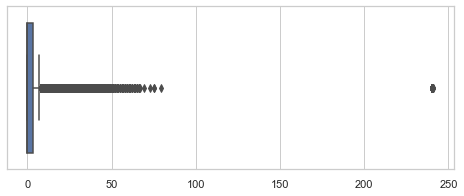

In [124]:

sns.set(rc={'figure.figsize':(8,3)})
sns.set_style("whitegrid")
sns.boxplot(subset_communication_metric)

In [125]:
for element in subset_communication_metric.columns.tolist():
    subset_communication_metric[element] = subset_communication_metric[element].apply(float)

for element in subset_communication_metric.columns.tolist():
    q25 = subset_communication_metric[element].quantile(0.25)
    q75 = subset_communication_metric[element].quantile(0.75)
    iqr = q75 - q25
    low = q25 - 6 * iqr
    high = q75 + 6 * iqr
    
    series = subset_communication_metric[element].between(low, high, inclusive=True)
    for index in series[series==False].index.tolist():
        subset_communication_metric.loc[index, element] = np.nan
    
    try: 
        print(element, ":", np.round(subset_communication_metric[element].isna().value_counts()[True]/len(subset_communication_metric),2)*100)
    except:
        0
    

HIT : 3.0


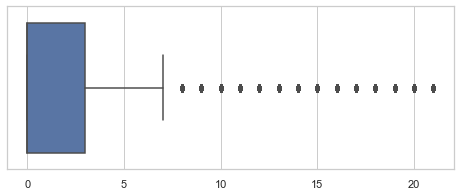

In [126]:

sns.set(rc={'figure.figsize':(8,3)})
sns.set_style("whitegrid")
sns.boxplot(subset_communication_metric)

In [127]:
for element in subset_communication_metric.columns.tolist():
    subset_communication_metric[element] = subset_communication_metric[element].replace(np.nan, subset_communication_metric[element].median())

Now, this subset is also ready for clustering now!

## Quick Summary

So we have now splitted the features into 9 different sets. This is especially helpful to better understand the given data. We have also identified and prepared all the metric features for the upcoming clustering. They can be seen here:

In [128]:
#subset 1
print(subset_neighbourhood_metric.shape)
subset_neighbourhood_metric.head()

(85404, 255)


,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,...,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2
0,992.0,264.0,332.0,0,35,65,47,53,92,1,...,0,33,65,40,99,99,6.0,2.0,10,7
1,3611.0,940.0,998.0,99,0,0,50,50,67,0,...,0,99,0,99,99,99,20.0,4.0,6,5
2,7001.0,2040.0,2669.0,0,2,98,49,51,96,2,...,15,22,77,17,97,92,9.0,2.0,6,5
3,640.0,160.0,219.0,0,8,92,54,46,61,0,...,16,23,77,22,93,89,16.0,2.0,6,6
4,2520.0,627.0,761.0,99,0,0,46,54,2,98,...,0,99,1,21,99,96,6.0,2.0,7,11


In [129]:
#subset 2
print(subset_socio_demographics_metric.shape)
subset_socio_demographics_metric.head()

(85404, 1)


,AGE
0,59.0
1,45.0
2,59.0
3,69.0
4,77.0


In [130]:
#subset 5
print(subset_overall_donation_data_metric.shape)
subset_overall_donation_data_metric.head()

(85404, 13)


,NUMPROM,NUMPRM12,RAMNTALL,NGIFTALL,MINRAMNT,MINRDATE,MAXRAMNT,MAXRDATE,LASTGIFT,LASTDATE,FISTDATE,TIMELAG,AVGGIFT
0,74.0,14.0,240.0,31.0,5.0,1765.0,12.0,1216.0,10.0,548.0,2769.0,4.0,7.741935
1,32.0,13.0,47.0,3.0,10.0,1339.0,25.0,548.0,25.0,548.0,1339.0,18.0,15.666667
2,63.0,14.0,202.0,27.0,2.0,2039.0,16.0,1796.0,5.0,548.0,2708.0,12.0,7.481481
3,66.0,14.0,109.0,16.0,2.0,3500.0,11.0,943.0,10.0,548.0,3773.0,9.0,6.812500
4,113.0,25.0,254.0,37.0,3.0,1339.0,15.0,517.0,15.0,517.0,6667.0,14.0,6.864865


In [131]:
#subset 9
print(subset_communication_metric.shape)
subset_communication_metric.head()

(85404, 1)


,HIT
0,0.0
1,16.0
2,2.0
3,2.0
4,0.0


As we can see, there are 278 features in total left. But only 16 of them do not belong to the donors neighbourhood.

In [132]:
metrics_without_neighbourhood = pd.concat([subset_socio_demographics_metric, subset_overall_donation_data_metric, subset_communication_metric], axis = 1)

In [133]:
print(metrics_without_neighbourhood.shape)
metrics_without_neighbourhood.head()

(85404, 15)


,AGE,NUMPROM,NUMPRM12,RAMNTALL,NGIFTALL,MINRAMNT,MINRDATE,MAXRAMNT,MAXRDATE,LASTGIFT,LASTDATE,FISTDATE,TIMELAG,AVGGIFT,HIT
0,59.0,74.0,14.0,240.0,31.0,5.0,1765.0,12.0,1216.0,10.0,548.0,2769.0,4.0,7.741935,0.0
1,45.0,32.0,13.0,47.0,3.0,10.0,1339.0,25.0,548.0,25.0,548.0,1339.0,18.0,15.666667,16.0
2,59.0,63.0,14.0,202.0,27.0,2.0,2039.0,16.0,1796.0,5.0,548.0,2708.0,12.0,7.481481,2.0
3,69.0,66.0,14.0,109.0,16.0,2.0,3500.0,11.0,943.0,10.0,548.0,3773.0,9.0,6.812500,2.0
4,77.0,113.0,25.0,254.0,37.0,3.0,1339.0,15.0,517.0,15.0,517.0,6667.0,14.0,6.864865,0.0


# Check for features that do not correlate with any others

As we now have all the metric features identified and preprocessed (apart from the normalization), we check if there are any features that are not correlating at all with others and are therefore useless for our clustering:

In [134]:
all_metrics = pd.concat([metrics_without_neighbourhood, subset_neighbourhood_metric], axis=1)
all_metrics.head()

,AGE,NUMPROM,NUMPRM12,RAMNTALL,NGIFTALL,MINRAMNT,MINRDATE,MAXRAMNT,MAXRDATE,LASTGIFT,...,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2
0,59.0,74.0,14.0,240.0,31.0,5.0,1765.0,12.0,1216.0,10.0,...,0,33,65,40,99,99,6.0,2.0,10,7
1,45.0,32.0,13.0,47.0,3.0,10.0,1339.0,25.0,548.0,25.0,...,0,99,0,99,99,99,20.0,4.0,6,5
2,59.0,63.0,14.0,202.0,27.0,2.0,2039.0,16.0,1796.0,5.0,...,15,22,77,17,97,92,9.0,2.0,6,5
3,69.0,66.0,14.0,109.0,16.0,2.0,3500.0,11.0,943.0,10.0,...,16,23,77,22,93,89,16.0,2.0,6,6
4,77.0,113.0,25.0,254.0,37.0,3.0,1339.0,15.0,517.0,15.0,...,0,99,1,21,99,96,6.0,2.0,7,11


In [ ]:
cor_all_metrics = all_metrics.corr()

In [ ]:
#for the detection of low correlating features we need to remove the 1 value for each feature that measures the correlation with itself
cor_all_metrics = cor_all_metrics.replace(1.0,0)

#then we take the abs of all the values, as we want to detect also low negative correlations
cor_all_metrics = cor_all_metrics.abs()

In [ ]:
#lower than 5%
low_cor = []
for element in cor_all_metrics.columns.tolist():
    if len(cor_all_metrics[element][cor_all_metrics[element]>0.05]) == 0:
        low_cor.append(element)

In [ ]:
print(low_cor)

In [ ]:
#lower than 10%
low_cor = []
for element in cor_all_metrics.columns.tolist():
    if len(cor_all_metrics[element][cor_all_metrics[element]>0.10]) == 0:
        low_cor.append(element)

In [ ]:
print(low_cor)

In [ ]:
cor_all_metrics["HIT"].sort_values(ascending=False).head(10)

As we can see, there are no features that have a correlation below 0.05 with any other feature. There is only one that has a lower than 0.1 correlation with all the others, which is HIT. We will drop this features, as it is therefore not suitable for our clustering.

In [ ]:
metrics_without_neighbourhood = metrics_without_neighbourhood.drop(columns=["HIT"])

# Normalizing the data

We now need to scale the variables, so that they are not distorting our clustering. We do this using the min max scaling method:

In [ ]:
#min max scaling

metrics_without_neighbourhood_bn = metrics_without_neighbourhood.copy()

cols = metrics_without_neighbourhood.columns
rows = metrics_without_neighbourhood.index

dic = {}
i = 0

for element in cols:
    dic[i]=element
    i = i + 1

x = metrics_without_neighbourhood.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
metrics_without_neighbourhood = pd.DataFrame(x_scaled)
metrics_without_neighbourhood = metrics_without_neighbourhood.rename(columns=dic)
metrics_without_neighbourhood.head()

Similarly, we do the same for the neighbourhood subset:

In [ ]:
#min max scaling

cols = subset_neighbourhood_metric.columns
rows = subset_neighbourhood_metric.index

dic = {}
i = 0

for element in cols:
    dic[i]=element
    i = i + 1

x = subset_neighbourhood_metric.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
subset_neighbourhood_metric = pd.DataFrame(x_scaled)
subset_neighbourhood_metric = subset_neighbourhood_metric.rename(columns=dic)
subset_neighbourhood_metric.head()

# PCA (Principle Component Analysis)

## PCA for neighbourhood subset

As we have just way too many features in the neighbourhood subset, we should apply some dimensionality reduction there. A suitable method for this is the PCA:

In [ ]:
pca = PCA()
pca_feat = pca.fit_transform(subset_neighbourhood_metric)
pca_feat

In [ ]:
#let's have a look at the covariance matrix
cov_matrix = subset_neighbourhood_metric.cov()
cov_matrix.head()

Now, we have the following 262 principle components:

In [ ]:
pd.DataFrame(subset_neighbourhood_metric.values @ pca.components_.T, 
             index=subset_neighbourhood_metric.index,
             columns=[f"PC{i}" for i in range(pca.n_components_)]).head()

This is obviously a too high amount of principle components, so we need to decide how many we will keep. There are three different rules of thumb criteria according to which we choose our principle components:
* The Eigenvalue of a principle component should be higher than 1
* The overall explained variance should be at least 65%
* The elbow point of the scree plot

Let's have a more detailed look into our PCA regarding these criteria.

In [ ]:
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
).head(15)

Let us plot this top 15:

In [ ]:
pca.explained_variance_ = pca.explained_variance_[:15]
pca.explained_variance_ratio_ = pca.explained_variance_ratio_[:15]

In [ ]:
sns.set_style("whitegrid")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative", color="skyblue")

ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, 15, 2))
ax1.set_xticklabels(range(1, 15 + 1, 2))
ax2.set_xticks(range(0, 15, 2))
ax2.set_xticklabels(range(1, 15 + 1, 2))
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

figure = ax1.get_figure()    
#figure.savefig('pca.png', dpi=1000)

#ax1.savefig("pca.png")

As we can see, we get some mixed information:
* According to the Eigenvalues, we should only keep one PC
* According to the Variance explained, we should keep 7 PCs
* According to the scree plot, we should probably keep 3 PCs

We decide to keep 7 PCs, as otherwise we would loose too much information!

#### Should we maybe just take the best for variance explained?!

Now, we have to perform the PCA again with only 7 PCs:

In [ ]:
pca = PCA(n_components=7)
pca_feat = pca.fit_transform(subset_neighbourhood_metric)
pca_feat_names = [f"PC{i}_Neighbourhood" for i in range(pca.n_components_)]
pca_subset_neighbourhood_metric = pd.DataFrame(pca_feat, index=subset_neighbourhood_metric.index, columns=pca_feat_names) 
pca_subset_neighbourhood_metric.head()

Now we have succesfully reduced the neighbourhood suset from 262 features to only 7. Great!

In [ ]:
metrics_with_neighbourhood = pd.concat([metrics_without_neighbourhood, pca_subset_neighbourhood_metric], axis = 1)
metrics_with_neighbourhood.head()

In [ ]:
metrics_with_neighbourhood.corr()

As we can see, the PCs of the neighbourhood subset are not correlating at all with the other features, so we will not include them for the later clustering.

# First Clustering approaches

# K Means Clustering

## K Means with neighbourhood PCs

### Defining the number of clusters:

In [ ]:
sns.set_style("whitegrid")
sse = {}
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(metrics_with_neighbourhood)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [ ]:
kmclust = KMeans(n_clusters=4, init='k-means++', n_init=15, random_state=1)
kmclust.fit(metrics_with_neighbourhood)

In [ ]:
metrics_with_neighbourhood['Cluster'] = kmclust.labels_

In [ ]:
metrics_with_neighbourhood.groupby("Cluster").mean()

In [ ]:
metrics_with_neighbourhood = metrics_with_neighbourhood.drop(columns=["Cluster"])

As we anticipated, the clustering gets biased too much by the neighbourhood PCs and therefore, there is almost no between cluster variation for the other features. This is not the best way to do it!

## K Means without neighbourhood PCs

In [ ]:
sns.set_style("whitegrid")
sse = {}
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(metrics_without_neighbourhood)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [ ]:
kmclust = KMeans(n_clusters=4, init='k-means++', n_init=15, random_state=1)
kmclust.fit(metrics_without_neighbourhood)

In [ ]:
metrics_without_neighbourhood['Cluster'] = kmclust.labels_
metrics_without_neighbourhood_bn['Cluster'] = kmclust.labels_

In [ ]:
#displaying the number of donors in each cluster
pd.DataFrame(metrics_without_neighbourhood.groupby("Cluster").count().iloc[:,0]).rename(columns={"AGE":"COUNT"})

In [ ]:
metrics_without_neighbourhood.groupby("Cluster").mean()

In [ ]:
metrics_without_neighbourhood = metrics_without_neighbourhood.drop(columns=["Cluster"])

## The final variables that will be used for clustering

The only feature that still doesn't really fit, is AGE, as all the other are from the donation and promotion data subset. So it kind of distorts our clustering, as it does not belong to this subset. Let's remove it and start our final clustering:

In [ ]:
metrics_without_neighbourhood = metrics_without_neighbourhood.drop(columns=["AGE"])

In [ ]:
#13 final variables
metrics_without_neighbourhood.columns.tolist()

## Exploring the final variables

As we've finally found our top 13 variables to perform the clustering with, let's explore them from scratch.

In [ ]:
top_13 = donors_co[metrics_without_neighbourhood.columns.tolist()]
print(top_13.shape)
top_13.head()

In [ ]:
#checking for nan
for element in top_13.columns.tolist():
    if len(top_13[element].dropna()) != len(top_13):
        print(element, np.round(100 - np.round(len(top_13[element].dropna())/len(top_13), 4)*100,4))

As we have no output here, we proved that there are NO nan values within this columns in the original donors.csv (there are some for timelag in the rows that are associated to one time donors, but as we know we excluded them from our analysis). That is amazing!

In [ ]:
top_13.describe()

In [ ]:
#relationship between our final variables
sns.set_style("whitegrid")
sns.pairplot(top_13)


Let us have a closer look into every feature:

In [ ]:

sns.set(rc={'figure.figsize':(4,6)})
sns.set_style("whitegrid")
sns.boxplot(data=top_13["NUMPROM"]).set(
    xlabel='NUMPROM', 
    ylabel='Amount')

In [ ]:
sns.set_style("whitegrid")
sns.boxplot(data=top_13["NUMPRM12"]).set(
    xlabel='NUMPROM12', 
    ylabel='Amount')

In [ ]:
sns.set_style("whitegrid")
sns.boxplot(data=top_13["RAMNTALL"]).set(
    xlabel='RAMNTALL', 
    ylabel='Amount')

In [ ]:
sns.set_style("whitegrid")
sns.boxplot(data=top_13["NGIFTALL"]).set(
    xlabel='NGIFTALL', 
    ylabel='Amount')

In [ ]:
sns.set_style("whitegrid")
sns.boxplot(data=top_13["MINRAMNT"]).set(
    xlabel='MINRAMNT', 
    ylabel='Amount')

In [ ]:
sns.set_style("whitegrid")
sns.boxplot(data=top_13["MINRDATE"]).set(
    xlabel='MINRDATE', 
    ylabel='Days ago')

In [ ]:
sns.set_style("whitegrid")
sns.boxplot(data=top_13["MAXRAMNT"]).set(
    xlabel='MAXRAMNT', 
    ylabel='Amount')

In [ ]:
sns.set_style("whitegrid")
sns.boxplot(data=top_13["MAXRDATE"]).set(
    xlabel='MAXRDATE', 
    ylabel='Days ago')

In [ ]:
sns.set_style("whitegrid")
sns.boxplot(data=top_13["LASTGIFT"]).set(
    xlabel='LASTGIFT', 
    ylabel='Amount')

In [ ]:
sns.set_style("whitegrid")
sns.boxplot(data=top_13["LASTDATE"]).set(
    xlabel='LASTDATE', 
    ylabel='Days ago')

In [ ]:
sns.set_style("whitegrid")
sns.boxplot(data=top_13["FISTDATE"]).set(
    xlabel='FISTDATE', 
    ylabel='Days ago')

In [ ]:
sns.set_style("whitegrid")
sns.boxplot(data=top_13["TIMELAG"]).set(
    xlabel='TIMELAG', 
    ylabel='Days')

In [ ]:
sns.set_style("whitegrid")
sns.boxplot(data=top_13["AVGGIFT"]).set(
    xlabel='AVGGIFT', 
    ylabel='Amount')

There are obviously outliers. Let us remove them. This time, we first remove the outliers by using the IQR method and then use the KNN Imputer to replace the resulting missing values, as it should give us more precise replacements. For the IQR method, we decide for each feature which multiplier is appropriate, in order to not loose to much information. Our goal is, to not remove more than 3% of values per column. This equals 0.03 * 85404 = 2562.

In [ ]:
#NUMPROM
q25 = top_13["NUMPROM"].quantile(0.25)
q75 = top_13["NUMPROM"].quantile(0.75)
iqr = q75 - q25
low = q25 - 1.5 * iqr
high = q75 + 1.5 * iqr

series = top_13["NUMPROM"].between(low, high, inclusive=True)

for index in series[series==False].index.tolist():
    top_13.loc[index, "NUMPROM"] = np.nan
        
print("NUMPROM amount of outliers:", len(top_13) - series.value_counts()[True])

In [ ]:
#NUMPRM12
q25 = top_13["NUMPRM12"].quantile(0.25)
q75 = top_13["NUMPRM12"].quantile(0.75)
iqr = q75 - q25
low = q25 - 7.5 * iqr
high = q75 + 7.5 * iqr

series = top_13["NUMPRM12"].between(low, high, inclusive=True)
print("NUMPRM12 amount of outliers:", len(top_13) - series.value_counts()[True])

for index in series[series==False].index.tolist():
    top_13.loc[index, "NUMPRM12"] = np.nan

In [ ]:
#RAMNTALL
q25 = top_13["RAMNTALL"].quantile(0.25)
q75 = top_13["RAMNTALL"].quantile(0.75)
iqr = q75 - q25
low = q25 - 2.5 * iqr
high = q75 + 2.5 * iqr

series = top_13["RAMNTALL"].between(low, high, inclusive=True)
print("RAMNTALL amount of outliers:", len(top_13) - series.value_counts()[True])

for index in series[series==False].index.tolist():
    top_13.loc[index, "RAMNTALL"] = np.nan
    

In [ ]:
#NGIFTALL
q25 = top_13["NGIFTALL"].quantile(0.25)
q75 = top_13["NGIFTALL"].quantile(0.75)
iqr = q75 - q25
low = q25 - 2 * iqr
high = q75 + 2 * iqr

series = top_13["NGIFTALL"].between(low, high, inclusive=True)
print("NGIFTALL amount of outliers:", len(top_13) - series.value_counts()[True])

for index in series[series==False].index.tolist():
    top_13.loc[index, "NGIFTALL"] = np.nan

In [ ]:
#MINRAMNT
q25 = top_13["MINRAMNT"].quantile(0.25)
q75 = top_13["MINRAMNT"].quantile(0.75)
iqr = q75 - q25
low = q25 - 1.5 * iqr
high = q75 + 1.5 * iqr

series = top_13["MINRAMNT"].between(low, high, inclusive=True)
print("MINRAMNT amount of outliers:", len(top_13) - series.value_counts()[True])

for index in series[series==False].index.tolist():
    top_13.loc[index, "MINRAMNT"] = np.nan

In [ ]:
#MINRDATE
q25 = top_13["MINRDATE"].quantile(0.25)
q75 = top_13["MINRDATE"].quantile(0.75)
iqr = q75 - q25
low = q25 - 1.5 * iqr
high = q75 + 1.5 * iqr

series = top_13["MINRDATE"].between(low, high, inclusive=True)
print("MINRDATE amount of outliers:", len(top_13) - series.value_counts()[True])

for index in series[series==False].index.tolist():
    top_13.loc[index, "MINRDATE"] = np.nan

In [ ]:
#MAXRAMNT
q25 = top_13["MAXRAMNT"].quantile(0.25)
q75 = top_13["MAXRAMNT"].quantile(0.75)
iqr = q75 - q25
low = q25 - 3 * iqr
high = q75 + 3 * iqr

series = top_13["MAXRAMNT"].between(low, high, inclusive=True)
print("MAXRAMNT amount of outliers:", len(top_13) - series.value_counts()[True])

for index in series[series==False].index.tolist():
    top_13.loc[index, "MAXRAMNT"] = np.nan

In [ ]:
#MAXRDATE
q25 = top_13["MAXRDATE"].quantile(0.25)
q75 = top_13["MAXRDATE"].quantile(0.75)
iqr = q75 - q25
low = q25 - 3.5 * iqr
high = q75 + 3.5 * iqr

series = top_13["MAXRDATE"].between(low, high, inclusive=True)
print("MAXRDATE amount of outliers:", len(top_13) - series.value_counts()[True])

for index in series[series==False].index.tolist():
    top_13.loc[index, "MAXRDATE"] = np.nan

In [ ]:
#LASTGIFT
q25 = top_13["LASTGIFT"].quantile(0.25)
q75 = top_13["LASTGIFT"].quantile(0.75)
iqr = q75 - q25
low = q25 - 2 * iqr
high = q75 + 2 * iqr

series = top_13["LASTGIFT"].between(low, high, inclusive=True)
print("LASTGIFT amount of outliers:", len(top_13) - series.value_counts()[True])

for index in series[series==False].index.tolist():
    top_13.loc[index, "LASTGIFT"] = np.nan

In [ ]:
#LASTDATE
q25 = top_13["LASTDATE"].quantile(0.25)
q75 = top_13["LASTDATE"].quantile(0.75)
iqr = q75 - q25
low = q25 - 2.5 * iqr
high = q75 + 2.5 * iqr

series = top_13["LASTDATE"].between(low, high, inclusive=True)
print("LASTDATE amount of outliers:", len(top_13) - series.value_counts()[True])

for index in series[series==False].index.tolist():
    top_13.loc[index, "LASTDATE"] = np.nan

In [ ]:
#FISTDATE
q25 = top_13["FISTDATE"].quantile(0.25)
q75 = top_13["FISTDATE"].quantile(0.75)
iqr = q75 - q25
low = q25 - 1.5 * iqr
high = q75 + 1.5 * iqr

series = top_13["FISTDATE"].between(low, high, inclusive=True)
print("FISTDATE amount of outliers:", len(top_13) - series.value_counts()[True])

for index in series[series==False].index.tolist():
    top_13.loc[index, "FISTDATE"] = np.nan

In [ ]:
#TIMELAG
q25 = top_13["TIMELAG"].quantile(0.25)
q75 = top_13["TIMELAG"].quantile(0.75)
iqr = q75 - q25
low = q25 - 2 * iqr
high = q75 + 2 * iqr

series = top_13["TIMELAG"].between(low, high, inclusive=True)
print("TIMELAG amount of outliers:", len(top_13) - series.value_counts()[True])

for index in series[series==False].index.tolist():
    top_13.loc[index, "TIMELAG"] = np.nan

In [ ]:
#AVGGIFT
q25 = top_13["AVGGIFT"].quantile(0.25)
q75 = top_13["AVGGIFT"].quantile(0.75)
iqr = q75 - q25
low = q25 - 2 * iqr
high = q75 + 2 * iqr

series = top_13["AVGGIFT"].between(low, high, inclusive=True)
print("AVGGIFT amount of outliers:", len(top_13) - series.value_counts()[True])

for index in series[series==False].index.tolist():
    top_13.loc[index, "AVGGIFT"] = np.nan

In [ ]:
#replacing the deleted values by using the KNN Imputer

In [ ]:
imputer = KNNImputer(n_neighbors=2)
top_13 = imputer.fit_transform(top_13)

In [ ]:
cols = metrics_without_neighbourhood.columns.tolist()

dic = {}
i = 0

for element in cols:
    dic[i]=element
    i = i + 1
    
top_13 = pd.DataFrame(top_13).rename(columns=dic)

Let us look again at the features, that are now outlier-free (at least to a certain degree):

In [ ]:
sns.set_style("whitegrid")
#relationship between our final variables
sns.pairplot(top_13)

In [ ]:
sns.set_style("whitegrid")
sns.boxplot(data=top_13["NUMPROM"]).set(
    xlabel='NUMPROM', 
    ylabel='Amount')

In [ ]:
sns.set_style("whitegrid")
sns.boxplot(data=top_13["NUMPRM12"]).set(
    xlabel='NUMPRM12', 
    ylabel='Amount')

In [ ]:
sns.set_style("whitegrid")
fig = sns.boxplot(data=top_13["RAMNTALL"])
#.set(
 #   xlabel='RAMNTALL', 
  #  ylabel='Amount')
sns.despine(right=True)
fig.set_xticks([])
plt.xlabel('')
plt.ylabel('')
plt.title("RAMNTALL in $")
fig = fig.get_figure()
#fig.savefig('RAMNTALL.png', dpi=1000)

In [ ]:
sns.set_style("whitegrid")
fig = sns.boxplot(data=top_13["NGIFTALL"])
sns.despine(right=True)
fig.set_xticks([])
plt.xlabel('')
plt.ylabel('')
plt.title("NGIFTALL")
fig = fig.get_figure()
#fig.savefig('NGIFTALL.png', dpi=1000)

In [ ]:
sns.set_style("whitegrid")
sns.boxplot(data=top_13["MINRAMNT"]).set(
    xlabel='MINRAMNT', 
    ylabel='Amount')

In [ ]:
sns.set_style("whitegrid")
sns.boxplot(data=top_13["MINRDATE"]).set(
    xlabel='MINRDATE', 
    ylabel='Days ago')

In [ ]:
sns.set_style("whitegrid")
sns.boxplot(data=top_13["MAXRAMNT"]).set(
    xlabel='MAXRAMNT', 
    ylabel='Amount')

In [ ]:
sns.set_style("whitegrid")
sns.boxplot(data=top_13["MAXRDATE"]).set(
    xlabel='MAXRDATE', 
    ylabel='Days ago')

In [ ]:
sns.set_style("whitegrid")
sns.boxplot(data=top_13["LASTGIFT"]).set(
    xlabel='LASTGIFT', 
    ylabel='Amount')

In [ ]:
sns.set_style("whitegrid")
fig = sns.boxplot(data=top_13["LASTDATE"])
sns.despine(right=True)
fig.set_xticks([])
plt.xlabel('')
plt.ylabel('')
plt.title("LASTDATE in days behind")
fig = fig.get_figure()
#fig.savefig('LASTDATE.png', dpi=1000)

In [ ]:
sns.set_style("whitegrid")
sns.boxplot(data=top_13["FISTDATE"]).set(
    xlabel='FISTDATE', 
    ylabel='Days ago')

In [ ]:
sns.set_style("whitegrid")
sns.boxplot(data=top_13["TIMELAG"]).set(
    xlabel='TIMELAG', 
    ylabel='Days')

In [ ]:
sns.set_style("whitegrid")
fig = sns.boxplot(data=top_13["AVGGIFT"])
sns.despine(right=True)
fig.set_xticks([])
plt.xlabel('')
plt.ylabel('AVGGIFT')
plt.title("AVGGIFT in $")
fig = fig.get_figure()
#fig.savefig('AVGGIFT.png', dpi=1000)


Alright, this looks now really good. Let's normalize the data now with the min max scaler and we are good to go:

In [ ]:
#min max scaling
top_13_co = top_13.copy()

cols = top_13.columns
rows = top_13.index

dic = {}
i = 0

for element in cols:
    dic[i]=element
    i = i + 1

x = top_13.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
top_13 = pd.DataFrame(x_scaled)
top_13 = top_13.rename(columns=dic)
top_13.head()

In [ ]:
metrics_without_neighbourhood = top_13

# FINAL CLUSTERING

We've reached the final stage of our clustering process and have also reached our final features, that we want to bas our clustering on. As we excluded the neighbourhood subset due to an unsufficient correlation with the other remaining features, we are still interested how a clustering based on the neighourhood subset would look like. So, we make our clustering from two different perspectives:
* I. The donation behaviour perspective
* II. The neighbourhood perspective

Furthermore, we will compare different clustering methods for each perspective:
1. Hierarchical Clustering
2. K Means Clustering
3. Mean Shift Clustering
4. DBSCAN
5. Gaussian Mixture Model (GMM)

We will compare them by using the R^2 for each.

# I. The donation behaviour perspective

In [ ]:
metrics_without_neighbourhood

## 1. Hierarchical Clustering

In [ ]:
sample_20= metrics_without_neighbourhood.sample(frac=0.2, replace=False)

In [ ]:
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(sample_20)

In [ ]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py
from scipy.cluster import hierarchy
# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
sns.set_style("whitegrid")
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 28
link_cols=[]
for i in range(15):
    link_cols = link_cols + link_cols
hierarchy.set_link_color_palette(["cornflowerblue", "lightsteelblue", "steelblue", "skyblue","cornflowerblue", "lightsteelblue", "steelblue", "skyblue"])
fig = dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k') #link_color_func=lambda x: link_cols[x])
#
plt.hlines(y_threshold, 0, 1000, colors="b", linestyles="dashed")
plt.title('', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)

sns.despine(right=True)
#plt.savefig('Dendogram.png', dpi=1000)


## 2. K Means Clustering

In [ ]:
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("whitegrid")
sse = {}
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(metrics_without_neighbourhood)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
#plt.title('Elbow curve for the neighborhood perspective')
plt.xlabel('k')
plt.ylabel('SSE')
fig = sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
sns.despine(right=True)
plt.show()

fig = fig.get_figure()
#fig.savefig('Elbow.png', dpi=1000)

while pd.DataFrame(metrics_without_neighbourhood.groupby("Cluster").count().iloc[:,0]).rename(columns={"RAMNTALL":"COUNT"}).iloc[0,0] != 24286:
    kmclust = KMeans(n_clusters=4, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(metrics_without_neighbourhood)
    metrics_without_neighbourhood['Cluster'] = kmclust.labels_
    metrics_without_neighbourhood_bn['Cluster'] = kmclust.labels_
    print(pd.DataFrame(metrics_without_neighbourhood.groupby("Cluster").count().iloc[:,0]).rename(columns={"RAMNTALL":"COUNT"}).iloc[0,0])


In [ ]:
kmclust = KMeans(n_clusters=4, init='k-means++', n_init=15, random_state=1)
kmclust.fit(metrics_without_neighbourhood)

In [ ]:
metrics_without_neighbourhood['Cluster'] = kmclust.labels_
metrics_without_neighbourhood_bn['Cluster'] = kmclust.labels_

In [ ]:
#displaying the number of donors in each cluster
pd.DataFrame(metrics_without_neighbourhood.groupby("Cluster").count().iloc[:,0]).rename(columns={"RAMNTALL":"COUNT"})

In [ ]:
metrics_without_neighbourhood.groupby("Cluster").mean()

In [ ]:
sns.set(rc={'figure.figsize':(15,10)})
sns.set_style("whitegrid")
sns.set_palette("pastel")

df_nor_melt = pd.melt(metrics_without_neighbourhood.reset_index(),
                      id_vars=["index", 'Cluster'],
                      value_vars=['NUMPROM',
 'NUMPRM12',
 'RAMNTALL',
 'NGIFTALL',
 'MINRAMNT',
 'MINRDATE',
 'MAXRAMNT',
 'MAXRDATE',
 'LASTGIFT',
 'LASTDATE',
 'FISTDATE',
 'TIMELAG',
 'AVGGIFT'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()
# Visualize it
fig = sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt, palette = "ch:start=.2,rot=-.3")
sns.despine(right=True)
plt.legend(loc="upper right", prop={'size': 15})
fig = fig.get_figure()
#fig.savefig('Variation.png', dpi=1000)

In [ ]:
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

sst = get_ss(metrics_without_neighbourhood.drop(columns=["Cluster"]))  # get total sum of squares
ssw_labels = metrics_without_neighbourhood.groupby(by='Cluster').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)
r2 = ssb / sst
print("R^2 kmeans:", r2)

## 3. Mean Shift Clustering

In [ ]:
#calculating the bandwidth
bandwidth = estimate_bandwidth(sample_20, quantile=0.6, random_state=1, n_jobs=-1)
bandwidth

In [ ]:
#estimating the number of clusters
ms = MeanShift(bandwidth=bandwidth,bin_seeding=True, n_jobs=4)
ms_labels = ms.fit_predict(sample_20)

ms_n_clusters = len(np.unique(ms_labels))
print("Number of estimated clusters:", ms_n_clusters)

In [ ]:
mean_shift_result = pd.concat([sample_20, pd.Series(ms_labels, index=sample_20.index, name="Cluster")], axis=1)
mean_shift_result.head()

In [ ]:
#displaying the number of donors in each cluster
pd.DataFrame(mean_shift_result.groupby("Cluster").count().iloc[:,0]).rename(columns={"RAMNTALL":"COUNT"})

In [ ]:
sst = get_ss(sample_20)  # get total sum of squares
ssw_labels = mean_shift_result.groupby(by='Cluster').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)
r2 = ssb / sst
print("R^2 mean shift:", r2)

## 4. DBSCAN

In [ ]:
neigh = NearestNeighbors(n_neighbors=26)
neigh.fit(sample_20)
distances, _ = neigh.kneighbors(sample_20)
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.show()

In [ ]:
dbscan = DBSCAN(eps=0.8, min_samples=26, n_jobs=4)
dbscan_labels = dbscan.fit_predict(sample_20)

dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters:", dbscan_n_clusters)

In [ ]:
dbscan_result = pd.concat([sample_20, pd.Series(dbscan_labels, index=sample_20.index, name="Cluster")], axis=1)
dbscan_result.head()

In [ ]:
#displaying the number of donors in each cluster
pd.DataFrame(dbscan_result.groupby("Cluster").count().iloc[:,0]).rename(columns={"RAMNTALL":"COUNT"})

In [ ]:
sst = get_ss(sample_20)  # get total sum of squares
ssw_labels = dbscan_result.groupby(by='Cluster').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)
r2 = ssb / sst
print("R^2 DBSCAN:", r2)

## 5. Gaussian Mixture Model (GMM)

In [ ]:
metrics_without_neighbourhood_gmm = metrics_without_neighbourhood.drop(columns=["Cluster"])

In [ ]:
n_components = np.arange(1, 10)
models = [GaussianMixture(n, covariance_type='full', n_init=10, random_state=1).fit(metrics_without_neighbourhood_gmm)
          for n in n_components]

bic_values = [m.bic(sample_20) for m in models]
aic_values = [m.aic(sample_20) for m in models]
fig = plt.plot(n_components, bic_values, label='BIC')
plt.plot(n_components, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(n_components)

plt.show()

In [ ]:
gmm = GaussianMixture(n_components=4, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)
gmm_labels = gmm.fit_predict(metrics_without_neighbourhood_gmm)

In [ ]:
gmm_result = pd.concat([metrics_without_neighbourhood_gmm, pd.Series(gmm_labels, index=metrics_without_neighbourhood_gmm.index, name="Cluster")], axis=1)
gmm_result.groupby("Cluster").mean()

In [ ]:
#displaying the number of donors in each cluster
pd.DataFrame(gmm_result.groupby("Cluster").count().iloc[:,0]).rename(columns={"RAMNTALL":"COUNT"})

In [ ]:
sst = get_ss(metrics_without_neighbourhood_gmm)  # get total sum of squares
ssw_labels = gmm_result.groupby(by='Cluster').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)
r2 = ssb / sst
print("R^2 GMM:", r2)

# II. The neighbourhood perspective

## 1. Hierarchical Clustering

In [ ]:
sample_20_ = pca_subset_neighbourhood_metric.sample(frac=0.2, replace=False)

In [ ]:
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(sample_20_)

In [ ]:
sns.set_style("whitegrid")
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
sns.set_style("whitegrid")
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 85
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
#plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
sns.despine(right=True)
plt.show()
#fig.savefig('Dendogram2.png', dpi=1000)


## 2. K Means Clustering

In [ ]:
pca_subset_neighbourhood_metric.head()

In [ ]:
sns.set_style("whitegrid")
sse = {}
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_subset_neighbourhood_metric)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
fig = sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()
sns.despine(right=True)

fig = fig.get_figure()
#fig.savefig('Elbow.png', dpi=1000)

In [ ]:
kmnclust = KMeans(n_clusters=4, init='k-means++', n_init=15, random_state=1)
kmnclust.fit(pca_subset_neighbourhood_metric)

In [ ]:
pca_subset_neighbourhood_metric['Cluster'] = kmnclust.labels_

In [ ]:
#displaying the number of donors in each cluster
pd.DataFrame(pca_subset_neighbourhood_metric.groupby("Cluster").count().iloc[:,0]).rename(columns={"PC0_Neighbourhood":"COUNT"})

In [ ]:
pca_subset_neighbourhood_metric.groupby("Cluster").mean()

In [ ]:
sns.set(rc={'figure.figsize':(15,10)})
sns.set_style("whitegrid")
sns.set_palette("pastel")

df_nor_melt = pd.melt(pca_subset_neighbourhood_metric.reset_index(),
                      id_vars=["index", 'Cluster'],
                      value_vars=['PC0_Neighbourhood',
 'PC1_Neighbourhood',
 'PC2_Neighbourhood',
 'PC3_Neighbourhood',
 'PC4_Neighbourhood',
 'PC5_Neighbourhood',
 'PC6_Neighbourhood'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()
# Visualize it
fig = sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt, palette = "ch:start=.2,rot=-.3")
sns.despine(right=True)
plt.legend(loc="lower right", prop={'size': 15})

fig = fig.get_figure()
#fig.savefig('NH7.png', dpi=1000)

In [ ]:
sns.set(rc={'figure.figsize':(5.5,6)})

In [ ]:
sst = get_ss(pca_subset_neighbourhood_metric.drop(columns=["Cluster"]))  # get total sum of squares
ssw_labels = pca_subset_neighbourhood_metric.groupby(by='Cluster').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)
r2 = ssb / sst
print("R^2 kmeans:", r2)

## 3. Mean Shift Clustering

In [ ]:
pca_subset_neighbourhood_metric = pca_subset_neighbourhood_metric.drop(columns=["Cluster"])

In [ ]:
#calculating the bandwidth
bandwidth = estimate_bandwidth(sample_20_, quantile=0.6, random_state=1, n_jobs=-1)
bandwidth

In [ ]:
#estimating the number of clusters
ms = MeanShift(bandwidth=bandwidth,bin_seeding=True, n_jobs=4)
ms_labels = ms.fit_predict(sample_20_)

ms_n_clusters = len(np.unique(ms_labels))
print("Number of estimated clusters:", ms_n_clusters)

In [ ]:
mean_shift_result_n = pd.concat([sample_20_, pd.Series(ms_labels, index=sample_20_.index, name="Cluster")], axis=1)
mean_shift_result_n.head()

In [ ]:
#displaying the number of donors in each cluster
pd.DataFrame(mean_shift_result_n.groupby("Cluster").count().iloc[:,0]).rename(columns={"RAMNTALL":"COUNT"})

In [ ]:
sst = get_ss(sample_20_)  # get total sum of squares
ssw_labels = mean_shift_result_n.groupby(by='Cluster').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)
r2 = ssb / sst
print("R^2 mean shift:", r2)

## 4. DBSCAN

In [ ]:
sns.set_style("whitegrid")
neigh = NearestNeighbors(n_neighbors=14)
neigh.fit(sample_20_)
distances, _ = neigh.kneighbors(sample_20_)
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.show()

In [ ]:
dbscan = DBSCAN(eps=1.0, min_samples=14, n_jobs=4)
dbscan_labels = dbscan.fit_predict(sample_20_)

dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters:", dbscan_n_clusters)

In [ ]:
dbscan_result_n = pd.concat([sample_20_, pd.Series(dbscan_labels, index=sample_20_.index, name="Cluster")], axis=1)
dbscan_result_n.head()

In [ ]:
#displaying the number of donors in each cluster
pd.DataFrame(dbscan_result_n.groupby("Cluster").count().iloc[:,0]).rename(columns={"RAMNTALL":"COUNT"})

In [ ]:
sst = get_ss(sample_20_)  # get total sum of squares
ssw_labels = dbscan_result_n.groupby(by='Cluster').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)
r2 = ssb / sst
print("R^2 DBSCAN:", r2)

## 5. Gaussian Mixture Model (GMM)

In [ ]:
pca_subset_neighbourhood_metric_gmm = pca_subset_neighbourhood_metric

In [ ]:
sns.set_style("whitegrid")
n_components = np.arange(1, 10)
models = [GaussianMixture(n, covariance_type='full', n_init=10, random_state=1).fit(pca_subset_neighbourhood_metric_gmm)
          for n in n_components]

bic_values = [m.bic(sample_20_) for m in models]
aic_values = [m.aic(sample_20_) for m in models]
plt.plot(n_components, bic_values, label='BIC')
plt.plot(n_components, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(n_components)
plt.show()

In [ ]:
gmm = GaussianMixture(n_components=5, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)
gmm_labels = gmm.fit_predict(pca_subset_neighbourhood_metric_gmm)

In [ ]:
gmm_result_n = pd.concat([pca_subset_neighbourhood_metric_gmm, pd.Series(gmm_labels, index=pca_subset_neighbourhood_metric_gmm.index, name="Cluster")], axis=1)
gmm_result_n.groupby("Cluster").mean()

In [ ]:
#displaying the number of donors in each cluster
pd.DataFrame(gmm_result_n.groupby("Cluster").count().iloc[:,0]).rename(columns={"RAMNTALL":"COUNT"})

In [ ]:
sst = get_ss(pca_subset_neighbourhood_metric_gmm)  # get total sum of squares
ssw_labels = gmm_result_n.groupby(by='Cluster').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)
r2 = ssb / sst
print("R^2 GMM:", r2)

# Preparing the categorical features for the analysis

In the following, we prepare the categorical features left in the subset for analysation purposes, by encoding them.

### subset: Neighbourhood

In [ ]:
#this subset is already good to go
subset_neighbourhood_metric.head()

### subset: demographics

In [ ]:
subset_socio_demographics.head()

In [ ]:
#checking for nans 
for element in subset_socio_demographics.columns.tolist():
    if len(subset_socio_demographics[element].dropna()) != len(subset_socio_demographics):
        print(element, np.round(100 - np.round(len(subset_socio_demographics[element].dropna())/len(subset_socio_demographics), 4)*100,4))

As we have too many nan values in the WEALTH1 and WEALTH2 columns, they will not provide quality information. We can drop them:

In [ ]:
#subset_socio_demographics = subset_socio_demographics.drop(columns = ["WEALTH1", "WEALTH2"])

In [ ]:
#checking for the amount of variation
for element in subset_socio_demographics.columns.tolist():
    if subset_socio_demographics[element].value_counts().iloc[0] != len(subset_socio_demographics):
        print(element, subset_socio_demographics[element].value_counts().iloc[0]/len(subset_socio_demographics))

So we drop the following columns due to a low amount of variations:

In [ ]:
try:

    subset_socio_demographics = subset_socio_demographics.drop(columns = ["PVASTATE", "CHILD03", "CHILD07", "CHILD12", "CHILD18"])
except:
    0

In [ ]:
# the following columns get dropped due to a lack of marketing relevant information
try:
    subset_socio_demographics = subset_socio_demographics.drop(columns = ["GEOCODE", "GEOCODE2", "ZIP"])
except:
    0

In [ ]:
#before encoding, we should transform the categorical column TCODE into string format
subset_socio_demographics["TCODE"] = subset_socio_demographics["TCODE"].apply(str)

In [ ]:
subset_socio_demographics.head()

Now, we encode all the categorical variables using one hot encoding:

In [ ]:
subset_socio_demographics_encoded = pd.get_dummies(subset_socio_demographics)

In [ ]:
#assigning the clusters to each donors
subset_socio_demographics['Cluster'] = kmclust.labels_
subset_socio_demographics_encoded['Cluster'] = kmclust.labels_

### subset: Responses to other types of mail order offers 

In [ ]:
#there is only the column DATASRC left in this subset 
subset_responses_to_others = pd.get_dummies(subset_responses_to_others)
subset_responses_to_others.head()

### subset: Donors interests

In [ ]:
#this subset contains the information about the interests of the donor
subset_interests_encoded = pd.get_dummies(subset_interests)
subset_interests_encoded.head()

### subset: Overall donation data

In [ ]:
#this subset was the core of our clustering and is already in a good form
subset_overall_donation_data.head()

### subset: Specific Promotions

In [ ]:
#the subset with the remaining information about the specfic promotions
subset_specific_promotions_encoded = pd.get_dummies(subset_specific_promotions)
subset_specific_promotions_encoded.head()

### subset: Major Donor Matrix

In [ ]:
#information about the major donors
subset_mdmaud_encoded = pd.get_dummies(subset_mdmaud)
subset_mdmaud_encoded.head()

### subset: Information about the communication with the donors

In [ ]:
subset_communication = subset_communication.drop(columns=["OSOURCE"])

In [ ]:
#information about the communication with the donors
subset_communication_encoded = pd.get_dummies(subset_communication)
subset_communication_encoded.head()

# Final clusters: The donation behaviour perspective

Let's have a deeper look on our clusters. We will display the major differences throuout all subsets between the clusters:

In [ ]:
#displaying the number of donors in each cluster
pd.DataFrame(metrics_without_neighbourhood_bn.groupby("Cluster").count().iloc[:,0]).rename(columns={"AGE":"COUNT"})

In [ ]:
cluster_means = metrics_without_neighbourhood_bn.groupby("Cluster").mean()
cluster_means

In [ ]:
cluster_means = cluster_means.append(metrics_without_neighbourhood_bn.mean(), ignore_index=True)
cluster_means["Cluster"] = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Average"]

In [ ]:
top_13_co["Cluster"] = kmclust.labels_
def plot_feature(df, col_name, isContinuous):
    
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    # Plot without loan status
    if isContinuous:
        sns.distplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df[col_name], order=sorted(df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Count')
    ax1.set_title(col_name + " disribution")
    plt.xticks(rotation = 90)

    # Plot with loan status
    if isContinuous:
        sns.boxplot(y=col_name, x='Cluster', data=df, ax=ax2, palette="Blues")
        ax2.set_ylabel('')
        ax2.set_title(col_name + ' by cluster')
        plt.xticks(rotation = 0)
    else:
        data = df.groupby(col_name)['Income'].value_counts(normalize=True).to_frame('proportion').reset_index()        
        sns.barplot(x = col_name, y = 'proportion', hue= "Income", data = data, saturation=1, ax=ax2)
        ax2.set_ylabel('Income fraction')
        ax2.set_title('Income status')
        plt.xticks(rotation = 90)
    ax2.set_xlabel(col_name)
    
    plt.tight_layout()
    sns.despine(right=True)
    figure = ax1.get_figure()    
    #figure.savefig(col_name+"clust", dpi=1000)
    


In [ ]:
sns.set(rc={'figure.figsize':(5.5,6)})
sns.set_style("whitegrid")
sns.set_palette("pastel")

fig = sns.barplot(x="Cluster", y = "AGE", data=cluster_means.sort_values("AGE", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in cluster_means.sort_values("AGE", ascending=False).Cluster])

sns.despine(right=True)
fig = fig.get_figure()
#fig.savefig("AGE.png", dpi=1000)



In [ ]:
sns.barplot(x="Cluster", y = "NUMPROM", data=cluster_means.sort_values("NUMPROM", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in cluster_means.sort_values("NUMPROM", ascending=False).Cluster]).set(
    xlabel='')
sns.despine(right=True)


In [ ]:
plot_feature(top_13_co, 'NUMPROM', True)

In [ ]:
sns.barplot(x="Cluster", y = "NUMPRM12", data=cluster_means.sort_values("NUMPRM12", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in cluster_means.sort_values("NUMPRM12", ascending=False).Cluster]).set(
    xlabel='')
sns.despine(right=True)

In [ ]:
plot_feature(top_13_co, 'NUMPRM12', True)

In [ ]:
sns.barplot(x="Cluster", y = "RAMNTALL", data=cluster_means.sort_values("RAMNTALL", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in cluster_means.sort_values("RAMNTALL", ascending=False).Cluster]).set(
    xlabel='')
sns.despine(right=True)

In [ ]:
plot_feature(top_13_co, 'RAMNTALL', True)

In [ ]:
sns.barplot(x="Cluster", y = "NGIFTALL", data=cluster_means.sort_values("NGIFTALL", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in cluster_means.sort_values("NGIFTALL", ascending=False).Cluster]).set(
    xlabel='')
sns.despine(right=True)

In [ ]:
plot_feature(top_13_co, 'NGIFTALL', True)


In [ ]:
sns.barplot(x="Cluster", y = "MINRAMNT", data=cluster_means.sort_values("MINRAMNT", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in cluster_means.sort_values("MINRAMNT", ascending=False).Cluster]).set(
    xlabel='')
sns.despine(right=True)

In [ ]:
plot_feature(top_13_co, 'MINRAMNT', True)

In [ ]:
sns.barplot(x="Cluster", y = "MAXRAMNT", data=cluster_means.sort_values("MAXRAMNT", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in cluster_means.sort_values("MAXRAMNT", ascending=False).Cluster]).set(
    xlabel='')
sns.despine(right=True)

In [ ]:
plot_feature(top_13_co, 'MAXRAMNT', True)

In [ ]:
sns.barplot(x="Cluster", y = "AVGGIFT", data=cluster_means.sort_values("AVGGIFT", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in cluster_means.sort_values("AVGGIFT", ascending=False).Cluster]).set(
    xlabel='')
sns.despine(right=True)

In [ ]:
plot_feature(top_13_co, 'AVGGIFT', True)

In [ ]:
sns.barplot(x="Cluster", y = "LASTGIFT", data=cluster_means.sort_values("LASTGIFT", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in cluster_means.sort_values("LASTGIFT", ascending=False).Cluster]).set(
    xlabel='')
sns.despine(right=True)

In [ ]:
plot_feature(top_13_co, 'LASTGIFT', True)

In [ ]:
sns.barplot(x="Cluster", y = "LASTDATE", data=cluster_means.sort_values("LASTDATE", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in cluster_means.sort_values("LASTDATE", ascending=False).Cluster]).set(
    xlabel='')
sns.despine(right=True)

In [ ]:
plot_feature(top_13_co, 'LASTDATE', True)

In [ ]:
sns.barplot(x="Cluster", y = "TIMELAG", data=cluster_means.sort_values("TIMELAG", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in cluster_means.sort_values("TIMELAG", ascending=False).Cluster]).set(
    xlabel='')
sns.despine(right=True)

In [ ]:
plot_feature(top_13_co, 'NUMPROM', True)

In [ ]:
plot_feature(top_13_co, 'FISTDATE', True)

### subset: Neighbourhood

In [ ]:
checking_for_deviation = abs(pd.concat([metrics_without_neighbourhood_bn,subset_neighbourhood], axis=1).groupby("Cluster").mean().pct_change()).sum() > 0.8

In [ ]:
checking_for_deviation = checking_for_deviation[checking_for_deviation==True]

In [ ]:
neighbourhood_analysis = pd.concat([metrics_without_neighbourhood_bn,subset_neighbourhood], axis=1).groupby("Cluster").mean()[checking_for_deviation.index.tolist()]

In [ ]:
neighbourhood_analysis = neighbourhood_analysis.iloc[:,10:]

In [ ]:
neighbourhood_analysis = neighbourhood_analysis.append(subset_neighbourhood[neighbourhood_analysis.columns.tolist()].mean(), ignore_index=True)
neighbourhood_analysis

In [ ]:
neighbourhood_analysis["Cluster"] = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Average"]

In [ ]:
neighbourhood_analysis

In [ ]:
sns.barplot(x="Cluster", y = "ETH7", data=neighbourhood_analysis.sort_values("ETH7", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in neighbourhood_analysis.sort_values("ETH7", ascending=False).Cluster]).set(
    xlabel='',ylabel="Percent Japanese")
sns.despine(right=True)

In [ ]:
sns.barplot(x="Cluster", y = "ETH8", data=neighbourhood_analysis.sort_values("ETH8", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in neighbourhood_analysis.sort_values("ETH8", ascending=False).Cluster]).set(
    xlabel='',ylabel="Percent Chinese")
sns.despine(right=True)

In [ ]:
sns.barplot(x="Cluster", y = "HVP1", data=neighbourhood_analysis.sort_values("HVP1", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in neighbourhood_analysis.sort_values("HVP1", ascending=False).Cluster]).set(
    xlabel='',ylabel="Percent Home Value >= $200,000")
sns.despine(right=True)

In [ ]:
fig = sns.barplot(x="Cluster", y = "HVP6", data=neighbourhood_analysis.sort_values("HVP6", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in neighbourhood_analysis.sort_values("HVP6", ascending=False).Cluster])

fig.set(xlabel='', ylabel='Percent Home Value >= $300,000')


sns.despine(right=True)
fig = fig.get_figure()
#fig.savefig("HVP6.png", dpi=1000)

In [ ]:
fig = sns.barplot(x="Cluster", y = "IC14", data=neighbourhood_analysis.sort_values("IC14", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in neighbourhood_analysis.sort_values("IC14", ascending=False).Cluster])

fig.set(xlabel='', ylabel='Percent Households w/ Income >= $150,000')

sns.despine(right=True)
fig = fig.get_figure()
#fig.savefig("IC14.png", dpi=1000)

In [ ]:
sns.barplot(x="Cluster", y = "AFC1", data=neighbourhood_analysis.sort_values("AFC1", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in neighbourhood_analysis.sort_values("AFC1", ascending=False).Cluster]).set(
    xlabel='',ylabel="Percent Adults in Active Military Service")
sns.despine(right=True)

### subset: demographics

In [ ]:
subset_socio_demographics.groupby("Cluster").count()

In [ ]:
check_sd = abs(subset_socio_demographics_encoded.groupby("Cluster").mean().pct_change().sum()) > 1

In [ ]:
check_sd = check_sd[check_sd==True]

In [ ]:
subset_socio_demographics_encoded_mean = subset_socio_demographics_encoded.mean()

In [ ]:
subset_socio_demographics_encoded = subset_socio_demographics_encoded.groupby("Cluster").mean()
try:
    subset_socio_demographics_encoded = subset_socio_demographics_encoded.drop(columns=["Cluster"])
except:
    0
subset_socio_demographics_encoded = subset_socio_demographics_encoded.append(subset_socio_demographics_encoded_mean, ignore_index=True)
subset_socio_demographics_encoded["Cluster"] = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Average"]
subset_socio_demographics_encoded.head()

In [ ]:
checks = check_sd.index.tolist()
checks.append("Cluster")
subset_socio_demographics_encoded = subset_socio_demographics_encoded[checks]

In [ ]:
subset_socio_demographics_encoded

In [ ]:
gender = pd.get_dummies(subset_socio_demographics["GENDER"])
gender_mean = gender.mean()
gender = pd.concat([gender, metrics_without_neighbourhood_bn["Cluster"]], axis = 1)
gender = gender.groupby("Cluster").mean().append(gender_mean, ignore_index=True)
gender["Cluster"] = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Average"]
gender.head()

In [ ]:
sns.barplot(x="Cluster", y = "M", data=gender.sort_values("M", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in gender.sort_values("M", ascending=False).Cluster]).set(
    xlabel='',ylabel="Percentage Males")
sns.despine(right=True)

In [ ]:
fig = sns.barplot(x="Cluster", y = "F", data=gender.sort_values("F", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in gender.sort_values("F", ascending=False).Cluster])#.set(
    #xlabel='',ylabel="Percentage Females")
plt.ylabel("Percentage of females")
sns.despine(right=True)
fig = fig.get_figure()
#fig.savefig("FEM.png", dpi=1000)




In [ ]:
mean_income = subset_socio_demographics["INCOME"].mean()

In [ ]:
mean_income = subset_socio_demographics["INCOME"].mean()
income = subset_socio_demographics[["INCOME", "Cluster"]].groupby("Cluster").mean()
income = income.T
income[4] = mean_income
income = income.T
income["Cluster"] = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Average"]

In [ ]:
sns.barplot(x="Cluster", y = "INCOME", data=income.sort_values("INCOME", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in income.sort_values("INCOME", ascending=False).Cluster]).set(
    xlabel='',ylabel="INCOME")
sns.despine(right=True)

Now we take a look into the geographical distributions of our clusters. Therefore, we will plot a map that displays each state with its according highest share of donors.

In [ ]:
c0 = pd.get_dummies(subset_socio_demographics[["STATE", "Cluster"]]).groupby("Cluster").sum().T[0].T.div(pd.get_dummies(subset_socio_demographics[["STATE", "Cluster"]]).groupby("Cluster").sum().T.sum()[0])
c1 = pd.get_dummies(subset_socio_demographics[["STATE", "Cluster"]]).groupby("Cluster").sum().T[1].T.div(pd.get_dummies(subset_socio_demographics[["STATE", "Cluster"]]).groupby("Cluster").sum().T.sum()[1])
c2 = pd.get_dummies(subset_socio_demographics[["STATE", "Cluster"]]).groupby("Cluster").sum().T[2].T.div(pd.get_dummies(subset_socio_demographics[["STATE", "Cluster"]]).groupby("Cluster").sum().T.sum()[2])
c3 = pd.get_dummies(subset_socio_demographics[["STATE", "Cluster"]]).groupby("Cluster").sum().T[3].T.div(pd.get_dummies(subset_socio_demographics[["STATE", "Cluster"]]).groupby("Cluster").sum().T.sum()[3])

In [ ]:
new_states_df = pd.concat([c0,c1,c2,c3],axis=1)

In [ ]:
c0_states = []
i=0
for element in new_states_df.index.tolist():
    if new_states_df.iloc[i,0] > new_states_df.iloc[i,1]:
        if new_states_df.iloc[i,0] > new_states_df.iloc[i,2]:
            if new_states_df.iloc[i,0] > new_states_df.iloc[i,3]:
                c0_states.append(element.replace("STATE_",""))
    i = i +1
    
c1_states = []
i=0
for element in new_states_df.index.tolist():
    if new_states_df.iloc[i,1] > new_states_df.iloc[i,0]:
        if new_states_df.iloc[i,1] > new_states_df.iloc[i,2]:
            if new_states_df.iloc[i,1] > new_states_df.iloc[i,3]:
                c1_states.append(element.replace("STATE_",""))
    i = i + 1
    
c2_states = []
i=0
for element in new_states_df.index.tolist():
    if new_states_df.iloc[i,2] > new_states_df.iloc[i,0]:
        if new_states_df.iloc[i,2] > new_states_df.iloc[i,1]:
            if new_states_df.iloc[i,2] > new_states_df.iloc[i,3]:
                c2_states.append(element.replace("STATE_",""))
    i = i +1
    
c3_states = []
i=0
for element in new_states_df.index.tolist():
    if new_states_df.iloc[i,3] > new_states_df.iloc[i,1]:
        if new_states_df.iloc[i,3] > new_states_df.iloc[i,2]:
            if new_states_df.iloc[i,3] > new_states_df.iloc[i,0]:
                c3_states.append(element.replace("STATE_",""))
    i = i +1

In [ ]:

states = geopandas.read_file('data/usa-states-census-2014.shp')
type(states)
states = states.to_crs("EPSG:3395")
c0 = states[states['STUSPS'].isin(c0_states)]
c1 = states[states['STUSPS'].isin(c1_states)]
c2 = states[states['STUSPS'].isin(c2_states)]
c3 = states[states['STUSPS'].isin(c3_states)]
us_boundary_map = states.boundary.plot(figsize=(18, 12), color='Black', linewidth=.5)
c0.plot(ax=us_boundary_map,  color="cornflowerblue")
c1.plot(ax=us_boundary_map, color="lightsteelblue")
c2.plot(ax=us_boundary_map, color="steelblue")
final_map = c3.plot(ax=us_boundary_map, color="skyblue")
final_map.grid(False)
c0_patch = mpatches.Patch(color='cornflowerblue', label='Cluster 0')
c1_patch = mpatches.Patch(color='lightsteelblue', label='Cluster 1')
c2_patch = mpatches.Patch(color='steelblue', label='Cluster 2')
c3_patch = mpatches.Patch(color='skyblue', label='Cluster 3')
plt.legend(handles=[c0_patch, c1_patch, c2_patch, c3_patch], loc="lower right", prop={'size': 18})

fig = final_map.get_figure()
fig.savefig("USA MAP", dpi=1000)

#plt.show()

In [ ]:
print(c0_states)

In [ ]:
print(c1_states)

In [ ]:
print(c2_states)

In [ ]:
print(c3_states)

### subset: Donors interests

In [ ]:
interests_mean = subset_interests_encoded.mean()

In [ ]:
subset_interests_encoded = pd.concat([subset_interests_encoded, metrics_without_neighbourhood_bn["Cluster"]], axis = 1)

In [ ]:
subset_interests_encoded = subset_interests_encoded.groupby("Cluster").mean().append(interests_mean, ignore_index=True)
subset_interests_encoded["Cluster"] = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Average"]

In [ ]:
sns.barplot(x="Cluster", y = "HOMEE_Y", data=subset_interests_encoded.sort_values("HOMEE_Y", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in subset_interests_encoded.sort_values("HOMEE_Y", ascending=False).Cluster]).set(
    xlabel='',ylabel="Percentage work from home")
sns.despine(right=True)

In [ ]:
sns.barplot(x="Cluster", y = "PCOWNERS_Y", data=subset_interests_encoded.sort_values("PCOWNERS_Y", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in subset_interests_encoded.sort_values("PCOWNERS_Y", ascending=False).Cluster]).set(
    xlabel='',ylabel="Percentage home PC owners/users")
sns.despine(right=True)

In [ ]:
sns.barplot(x="Cluster", y = "CARDS_Y", data=subset_interests_encoded.sort_values("CARDS_Y", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in subset_interests_encoded.sort_values("CARDS_Y", ascending=False).Cluster]).set(
    xlabel='',ylabel="Percentage stationary/cards buyer")
sns.despine(right=True)

###  subset: Major Donor Matrix

In [ ]:
mdm_mean = subset_mdmaud_encoded.mean()
subset_mdmaud_encoded = pd.concat([subset_mdmaud_encoded, metrics_without_neighbourhood_bn["Cluster"]], axis = 1)
subset_mdmaud_encoded = subset_mdmaud_encoded.groupby("Cluster").mean().append(mdm_mean, ignore_index=True)
subset_mdmaud_encoded["Cluster"] = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Average"]
subset_mdmaud_encoded.head()

In [ ]:
sns.barplot(x="Cluster", y = "MAJOR_X", data=subset_mdmaud_encoded.sort_values("MAJOR_X", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in subset_mdmaud_encoded.sort_values("MAJOR_X", ascending=False).Cluster]).set(
    xlabel='',ylabel="Percentage Major Donors")
sns.despine(right=True)

### subset: Information about the communication with the donors

In [ ]:
com_mean = subset_communication_encoded.mean()
subset_communication_encoded = pd.concat([subset_communication_encoded, metrics_without_neighbourhood_bn["Cluster"]], axis = 1)
subset_communication_encoded = subset_communication_encoded.groupby("Cluster").mean().append(com_mean, ignore_index=True)
subset_communication_encoded["Cluster"] = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Average"]


In [ ]:
subset_communication_encoded.head()

In [ ]:
fig = sns.barplot(x="Cluster", y = "PEPSTRFL_X", data=subset_communication_encoded.sort_values("PEPSTRFL_X", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in subset_communication_encoded.sort_values("PEPSTRFL_X", ascending=False).Cluster])#.set(
plt.ylabel("Percentage PEP Star RFA Status")
sns.despine(right=True)
fig = fig.get_figure()
#fig.savefig("PEP.png", dpi=1000)




In [ ]:
sns.barplot(x="Cluster", y = "RECINHSE_X", data=subset_communication_encoded.sort_values("RECINHSE_X", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in subset_communication_encoded.sort_values("RECINHSE_X", ascending=False).Cluster]).set(
    xlabel='',ylabel="Percentage Donor has given to PVA's In House program")
sns.despine(right=True)

In [ ]:
sns.barplot(x="Cluster", y = "SOLIH_00", data=subset_communication_encoded.sort_values("SOLIH_00", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in subset_communication_encoded.sort_values("SOLIH_00", ascending=False).Cluster]).set(
    xlabel='',ylabel="Percentage Do Not Solicit")
sns.despine(right=True)

In [ ]:
sns.barplot(x="Cluster", y = "HIT", data=subset_communication_encoded.sort_values("HIT", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in subset_communication_encoded.sort_values("HIT", ascending=False).Cluster]).set(
    xlabel='',ylabel="Mail Order Response")
sns.despine(right=True)

Let's check how our lapsing donors are distributed accross the Clusters:

In [ ]:
#displaying the number of observations grouped by the amount of days their last donation lies behind
days_past = pd.DataFrame(donors["LASTDATE"].value_counts()).reset_index().rename(columns={"index":"Days in the past"}).sort_values(by="Days in the past")
days_past

In [ ]:
metrics_without_neighbourhood_bn["Cluster"]= kmclust.labels_

In [ ]:
lapsed = metrics_without_neighbourhood_bn[["LASTDATE", "Cluster"]]

In [ ]:
lapsed.groupby("Cluster").count()

In [ ]:
c0_ = lapsed[lapsed["Cluster"] == 0]
c1_ = lapsed[lapsed["Cluster"] == 1]
c2_ = lapsed[lapsed["Cluster"] == 2]
c3_ = lapsed[lapsed["Cluster"] == 3]

In [ ]:
print("Percentage of lapsed donors in Cluster 0:", np.round(len(c0_[(c0_["LASTDATE"] <=732) & (365 <= c0_["LASTDATE"])])/len(c0_),3)*100)
print("Percentage of lapsed donors in Cluster 1:", np.round(len(c1_[(c1_["LASTDATE"] <=732) & (365 <= c1_["LASTDATE"])])/len(c1_),3)*100)
print("Percentage of lapsed donors in Cluster 2:", np.round(len(c2_[(c2_["LASTDATE"] <=732) & (365 <= c2_["LASTDATE"])])/len(c2_),3)*100)
print("Percentage of lapsed donors in Cluster 3:", np.round(len(c3_[(c3_["LASTDATE"] <=732) & (365 <= c3_["LASTDATE"])])/len(c3_),3)*100)

# Final clusters: The neighbourhood perspective

In [ ]:
#displaying the number of donors in each cluster
try:
    pd.DataFrame(pca_subset_neighbourhood_metric.groupby("Cluster").count().iloc[:,0]).rename(columns={"PC0_Neighbourhood":"COUNT"})
except:
    0

### Subset neighbourhood

In [ ]:
subset_neighbourhood["Cluster"] = kmnclust.labels_

In [ ]:
checking_for_deviation = abs(subset_neighbourhood.groupby("Cluster").mean().pct_change()).sum() > 7
checking_for_deviation = checking_for_deviation[checking_for_deviation==True]
checking_for_deviation.head()

In [ ]:
print(checking_for_deviation.index.tolist())

In [ ]:
subset_neighbourhood_mean = subset_neighbourhood.mean()
subset_neighbourhood = subset_neighbourhood.groupby("Cluster").mean()
subset_neighbourhood = subset_neighbourhood.append(subset_neighbourhood_mean, ignore_index=True)

In [ ]:
subset_neighbourhood["Cluster"] = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Average"]

In [ ]:
sns.barplot(x="Cluster", y = "POP90C1", data=subset_neighbourhood.sort_values("POP90C1", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in subset_neighbourhood.sort_values("POP90C1", ascending=False).Cluster]).set(
    xlabel='',ylabel="Percent Population in Urbanized Area")
sns.despine(right=True)

In [ ]:
sns.barplot(x="Cluster", y = "POP90C3", data=subset_neighbourhood.sort_values("POP90C3", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in subset_neighbourhood.sort_values("POP90C3", ascending=False).Cluster]).set(
    xlabel='',ylabel="Percent Population Inside Rural Area")
sns.despine(right=True)

In [ ]:
sns.barplot(x="Cluster", y = "DW6", data=subset_neighbourhood.sort_values("DW6", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in subset_neighbourhood.sort_values("DW6", ascending=False).Cluster]).set(
    xlabel='',ylabel="Percent Housing Units in 5+ Unit Structure")
sns.despine(right=True)

In [ ]:
sns.barplot(x="Cluster", y = "HVP6", data=subset_neighbourhood.sort_values("HVP6", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in subset_neighbourhood.sort_values("HVP6", ascending=False).Cluster]).set(
    xlabel='',ylabel="Percent Home Value >= $300,000")
sns.despine(right=True)

In [ ]:
sns.barplot(x="Cluster", y = "HC18", data=subset_neighbourhood.sort_values("HC18", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in subset_neighbourhood.sort_values("HC18", ascending=False).Cluster]).set(
    xlabel='',ylabel="Percent Housing Units w/ Well Water Source")
sns.despine(right=True)

### Subset demographics

In [ ]:
subset_socio_demographics["Cluster"] = kmnclust.labels_
subset_socio_demographics.head()

In [ ]:
means = subset_socio_demographics.groupby("Cluster").mean()

In [ ]:
means = means.append(subset_socio_demographics.mean(), ignore_index=True)
means["Cluster"] = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Average"]

In [ ]:
sns.barplot(x="Cluster", y = "AGE", data=means.sort_values("AGE", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in means.sort_values("AGE", ascending=False).Cluster]).set(
    xlabel='')
sns.despine(right=True)

In [ ]:
sns.barplot(x="Cluster", y = "INCOME", data=means.sort_values("INCOME", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in means.sort_values("INCOME", ascending=False).Cluster]).set(
    xlabel='')
sns.despine(right=True)

In [ ]:
gender = pd.get_dummies(subset_socio_demographics["GENDER"])
gender_mean = gender.mean()
gender = pd.concat([gender, subset_socio_demographics["Cluster"]], axis = 1)
gender = gender.groupby("Cluster").mean().append(gender_mean, ignore_index=True)
gender["Cluster"] = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Average"]
gender.head()

In [ ]:
sns.barplot(x="Cluster", y = "M", data=gender.sort_values("M", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in gender.sort_values("M", ascending=False).Cluster]).set(
    xlabel='',ylabel="Percentage Males")
sns.despine(right=True)

In [ ]:
sns.barplot(x="Cluster", y = "F", data=gender.sort_values("F", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in gender.sort_values("F", ascending=False).Cluster]).set(
    xlabel='',ylabel="Percentage Females")
sns.despine(right=True)

In [ ]:
gender = pd.get_dummies(subset_socio_demographics["HOMEOWNR"])
gender_mean = gender.mean()
gender = pd.concat([gender, subset_socio_demographics["Cluster"]], axis = 1)
gender = gender.groupby("Cluster").mean().append(gender_mean, ignore_index=True)
gender["Cluster"] = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Average"]
gender.head()

In [ ]:
sns.barplot(x="Cluster", y = "H", data=gender.sort_values("H", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in gender.sort_values("H", ascending=False).Cluster]).set(
    xlabel='',ylabel="Percentage Homeowners")
sns.despine(right=True)

### Subset donors interests

In [ ]:
subset_interests_encoded = pd.get_dummies(subset_interests)

In [ ]:
interests_mean = subset_interests_encoded.mean()
subset_interests_encoded["Cluster"] = kmnclust.labels_

In [ ]:
subset_interests_encoded = subset_interests_encoded.groupby("Cluster").mean().append(interests_mean, ignore_index=True)
subset_interests_encoded["Cluster"] = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Average"]

In [ ]:
subset_interests_encoded.iloc[:,20:]

In [ ]:
sns.barplot(x="Cluster", y = "VETERANS_Y", data=subset_interests_encoded.sort_values("VETERANS_Y", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in subset_interests_encoded.sort_values("VETERANS_Y", ascending=False).Cluster]).set(
    xlabel='',ylabel="Percentage veterans interests")
sns.despine(right=True)

In [ ]:
sns.barplot(x="Cluster", y = "BIBLE_Y", data=subset_interests_encoded.sort_values("BIBLE_Y", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in subset_interests_encoded.sort_values("BIBLE_Y", ascending=False).Cluster]).set(
    xlabel='',ylabel="Percentage bible reading")
sns.despine(right=True)

In [ ]:
sns.barplot(x="Cluster", y = "HOMEE_Y", data=subset_interests_encoded.sort_values("HOMEE_Y", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in subset_interests_encoded.sort_values("HOMEE_Y", ascending=False).Cluster]).set(
    xlabel='',ylabel="Percentage working from home")
sns.despine(right=True)

In [ ]:
sns.barplot(x="Cluster", y = "PCOWNERS_Y", data=subset_interests_encoded.sort_values("PCOWNERS_Y", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in subset_interests_encoded.sort_values("PCOWNERS_Y", ascending=False).Cluster]).set(
    xlabel='',ylabel="Percentage home PC owners/users")
sns.despine(right=True)

In [ ]:
sns.barplot(x="Cluster", y = "FISHER_Y", data=subset_interests_encoded.sort_values("FISHER_Y", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in subset_interests_encoded.sort_values("FISHER_Y", ascending=False).Cluster]).set(
    xlabel='',ylabel="Percentage fishing interests")
sns.despine(right=True)

### Subset donation behaviour

In [ ]:
metrics_without_neighbourhood_bn["Cluster"] = kmnclust.labels_

In [ ]:
cluster_means = metrics_without_neighbourhood_bn.groupby("Cluster").mean()
cluster_means = cluster_means.append(metrics_without_neighbourhood_bn.mean(), ignore_index=True)
cluster_means["Cluster"] = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Average"]

In [ ]:
sns.barplot(x="Cluster", y = "NUMPROM", data=cluster_means.sort_values("NUMPROM", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in cluster_means.sort_values("NUMPROM", ascending=False).Cluster]).set(
    xlabel='')
sns.despine(right=True)

In [ ]:
sns.barplot(x="Cluster", y = "NUMPRM12", data=cluster_means.sort_values("NUMPRM12", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in cluster_means.sort_values("NUMPRM12", ascending=False).Cluster]).set(
    xlabel='')
sns.despine(right=True)

In [ ]:
sns.barplot(x="Cluster", y = "RAMNTALL", data=cluster_means.sort_values("RAMNTALL", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in cluster_means.sort_values("RAMNTALL", ascending=False).Cluster]).set(
    xlabel='')
sns.despine(right=True)

In [ ]:
sns.barplot(x="Cluster", y = "NGIFTALL", data=cluster_means.sort_values("NGIFTALL", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in cluster_means.sort_values("NGIFTALL", ascending=False).Cluster]).set(
    xlabel='')
sns.despine(right=True)

In [ ]:
sns.barplot(x="Cluster", y = "AVGGIFT", data=cluster_means.sort_values("AVGGIFT", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in cluster_means.sort_values("AVGGIFT", ascending=False).Cluster]).set(
    xlabel='')
sns.despine(right=True)

In [ ]:
sns.barplot(x="Cluster", y = "LASTGIFT", data=cluster_means.sort_values("LASTGIFT", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in cluster_means.sort_values("LASTGIFT", ascending=False).Cluster]).set(
    xlabel='')
sns.despine(right=True)

In [ ]:
sns.barplot(x="Cluster", y = "LASTDATE", data=cluster_means.sort_values("LASTDATE", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in cluster_means.sort_values("LASTDATE", ascending=False).Cluster]).set(
    xlabel='')
sns.despine(right=True)

In [ ]:
sns.barplot(x="Cluster", y = "TIMELAG", data=cluster_means.sort_values("TIMELAG", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in cluster_means.sort_values("TIMELAG", ascending=False).Cluster]).set(
    xlabel='')
sns.despine(right=True)

### Subset major donors

In [ ]:
subset_mdmaud_encoded = pd.get_dummies(subset_mdmaud)
mdm_mean = subset_mdmaud_encoded.mean()
subset_mdmaud_encoded = pd.concat([subset_mdmaud_encoded, metrics_without_neighbourhood_bn["Cluster"]], axis = 1)
subset_mdmaud_encoded = subset_mdmaud_encoded.groupby("Cluster").mean().append(mdm_mean, ignore_index=True)
subset_mdmaud_encoded["Cluster"] = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Average"]
subset_mdmaud_encoded.head()

In [ ]:
sns.barplot(x="Cluster", y = "MAJOR_X", data=subset_mdmaud_encoded.sort_values("MAJOR_X", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in subset_mdmaud_encoded.sort_values("MAJOR_X", ascending=False).Cluster]).set(
    xlabel='',ylabel="Percentage Major Donors")
sns.despine(right=True)

### Subset communication

In [ ]:
subset_communication_encoded = pd.get_dummies(subset_communication)
com_mean = subset_communication_encoded.mean()
subset_communication_encoded = pd.concat([subset_communication_encoded, metrics_without_neighbourhood_bn["Cluster"]], axis = 1)
subset_communication_encoded = subset_communication_encoded.groupby("Cluster").mean().append(com_mean, ignore_index=True)
subset_communication_encoded["Cluster"] = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Average"]
subset_communication_encoded.head()

In [ ]:
sns.barplot(x="Cluster", y = "PEPSTRFL_X", data=subset_communication_encoded.sort_values("PEPSTRFL_X", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in subset_communication_encoded.sort_values("PEPSTRFL_X", ascending=False).Cluster]).set(
    xlabel='',ylabel="Percentage PEP Star RFA Status")
sns.despine(right=True)

In [ ]:
sns.barplot(x="Cluster", y = "RECINHSE_X", data=subset_communication_encoded.sort_values("RECINHSE_X", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in subset_communication_encoded.sort_values("RECINHSE_X", ascending=False).Cluster]).set(
    xlabel='',ylabel="Percentage Donor has given to PVA's In House program")
sns.despine(right=True)

In [ ]:
sns.barplot(x="Cluster", y = "SOLIH_00", data=subset_communication_encoded.sort_values("SOLIH_00", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in subset_communication_encoded.sort_values("SOLIH_00", ascending=False).Cluster]).set(
    xlabel='',ylabel="Percentage Do Not Solicit")
sns.despine(right=True)

In [ ]:
sns.barplot(x="Cluster", y = "HIT", data=subset_communication_encoded.sort_values("HIT", ascending=False), palette=["cornflowerblue" if x!='Average' else 'navy' for x in subset_communication_encoded.sort_values("HIT", ascending=False).Cluster]).set(
    xlabel='',ylabel="Mail Order Response")
sns.despine(right=True)

## PCA for visualization purposes

Similarly to the above PCA, we perform another one for the remaining features in order to get the data ready for visualization. However, we don't need to identify the correct number of PCs here, as we will use it for visualization purposes only and therefore need 2 PCs for 2 dimensional and 3 PCs for 3 dimensional visualizations no matter what:

In [ ]:
metrics_without_neighbourhood_ = metrics_without_neighbourhood.drop(columns=["Cluster"])

pca = PCA(n_components=2)
pca_feat = pca.fit_transform(metrics_without_neighbourhood_)
pca_feat

In [ ]:
two_d = pd.DataFrame(metrics_without_neighbourhood_.values @ pca.components_.T, 
             index=subset_neighbourhood_metric.index,
             columns=[f"PC{i}" for i in range(pca.n_components_)])
two_d.head()

In [ ]:
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
)

So the first two PCs explain about 62% of the variance.

In [ ]:
pca = PCA(n_components=3)
pca_feat = pca.fit_transform(metrics_without_neighbourhood_)
pca_feat

In [ ]:
three_d = pd.DataFrame(metrics_without_neighbourhood_.values @ pca.components_.T, 
             index=subset_neighbourhood_metric.index,
             columns=[f"PC{i}" for i in range(pca.n_components_)])
three_d.head()

In [ ]:
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
)

Okay, this already explains over 85% of the variance, so the 3d visualization will be very meaningful!

## Visualization

In [ ]:
two_d["Cluster"] = kmclust.labels_
three_d["Cluster"] = kmclust.labels_

In [ ]:
sns.set_style("whitegrid")
#adapted from:
#https://www.kaggle.com/minc33/visualizing-high-dimensional-clusters

cluster0 = two_d[two_d["Cluster"] == 0]
cluster1 = two_d[two_d["Cluster"] == 1]
cluster2 = two_d[two_d["Cluster"] == 2]
cluster3 = two_d[two_d["Cluster"] == 3]

trace1 = go.Scatter(
                    x = cluster0["PC0"],
                    y = cluster0["PC1"],
                    mode = "markers",
                    name = "Cluster 0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = None)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter(
                    x = cluster1["PC0"],
                    y = cluster1["PC1"],
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = None)

#trace3 is for 'Cluster 2'
trace3 = go.Scatter(
                    x = cluster2["PC0"],
                    y = cluster2["PC1"],
                    mode = "markers",
                    name = "Cluster 2",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text = None)

#trace4 is for 'Cluster 3'
trace4 = go.Scatter(
                    x = cluster3["PC0"],
                    y = cluster3["PC1"],
                    mode = "markers",
                    name = "Cluster 3",
                    marker = dict(color = 'rgba(200, 10, 0, 0.8)'),
                    text = None)

data = [trace1, trace2, trace3, trace4]

title = "Visualizing Clusters in Two Dimensions Using PCA"

layout = dict(title = title,
              xaxis= dict(title= 'PC0',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'PC1',ticklen= 5,zeroline= False)
             )

sns.set_style("whitegrid")
fig = dict(data = data, layout = layout)

sns.set_style("whitegrid")
sns.set(style="white", color_codes=True)
iplot(fig)
#fig = fig.get_figure()
#fig.savefig()

We see that this doesn't look very good, because there doesn't seem to be any clusters that directly catch our eyes at first sight. But as we explained above, this displays not even 50% of our varaince, so let's have a look into the 3 dimensional visualization:

In [ ]:
sns.set_style("whitegrid")
#adapted from:
#https://www.kaggle.com/minc33/visualizing-high-dimensional-clusters

cluster0 = three_d[three_d["Cluster"] == 0]
cluster1 = three_d[three_d["Cluster"] == 1]
cluster2 = three_d[three_d["Cluster"] == 2]
cluster3 = three_d[three_d["Cluster"] == 3]

#trace1 is for 'Cluster 0'
trace1 = go.Scatter3d(
                    x = cluster0["PC0"],
                    y = cluster0["PC1"],
                    z = cluster0["PC2"],
                    mode = "markers",
                    name = "Cluster 0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = None)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter3d(
                    x = cluster1["PC0"],
                    y = cluster1["PC1"],
                    z = cluster1["PC2"],
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = None)

#trace3 is for 'Cluster 2'
trace3 = go.Scatter3d(
                    x = cluster2["PC0"],
                    y = cluster2["PC1"],
                    z = cluster2["PC2"],
                    mode = "markers",
                    name = "Cluster 2",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text = None)

#trace4 is for 'Cluster 3'
trace4 = go.Scatter3d(
                    x = cluster3["PC0"],
                    y = cluster3["PC1"],
                    z = cluster3["PC2"],
                    mode = "markers",
                    name = "Cluster 3",
                    marker = dict(color = 'rgba(200, 10, 0, 0.8)'),
                    text = None)

data = [trace1, trace2, trace3, trace4]

title = "Visualizing Clusters in Three Dimensions Using PCA"

layout = dict(title = title,
              xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)